<h1>Credit Risk Assessment</h1>

<h2>Project Goals:</h2>
    Analyze borrower profiles and their financial behavior<br>
    Create a classification model to identify reliable and high-risk clients.<br>
    Build a dashboard to highlight segments that may be riskier, more profitable, or require different underwriting policies<br>

<h2>Project Stages:</h2>

<h3>Data Preparation</h3>
    Removing duplicates, handling missing values and outliers, analyzing variable distributions

<h3>Exploratory Analysis:</h3>

<h5>Financial Profile:</h5>
What is the average loan_percent_income across different income levels?<br>
Who most often takes out large loans — by age, experience, property type?<br>
How are income and interest rate (loan_int_rate) related?<br>
How does loan_percent_income vary depending on credit grade (loan_grade)?<br>
<h5>Credit History and Risk:</h5>
How does credit history length (cred_hist_length) affect loan amount?<br>
What is the average credit history length across age groups?<br>
How is default history (cb_person_default_on_file) related to interest rate?<br>
Who has more defaults — by age, loan purpose, or employment status?<br>
<h5>Dependence on Loan Purpose:</h5>
Which loan purposes are more often linked to large amounts?<br>
Which loan intents have a higher share of borrowers with default history?<br>
    
<h5>For the Classification Model:</h5>
Encoding categorical variables and scaling all features<br>
Which features are most informative for predicting default?<br>
Which features are correlated?<br>
How does loan_grade affect default probability?<br>
Is there multicollinearity — especially among features like interest rate / amount / income?<br>

<h3>Model Building</h3>
    Choosing an algorithm and building the classifier<br>
    Evaluating and improving the model<br>
    Predicting client classes on new data<br>

<h3>Dashboard Creation</h3>
    Creating visualizations:<br>
    What is the average loan amount by loan purpose?<br>
    How do interest rates differ by loan purpose?<br>
    How is borrower age distributed by loan purpose?<br>
    What is the average credit burden by loan purpose?<br>
    How does homeownership category vary by loan purpose?<br>
    How is credit score related to loan purpose?<br>


In [808]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import randint
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler 
from sklearn.model_selection import train_test_split, cross_val_score,  RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_curve,\
roc_auc_score, roc_curve, fbeta_score, cohen_kappa_score, matthews_corrcoef
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

In [810]:
df = pd.read_csv('credit_risk.csv')

In [812]:
df

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,26,200100,MORTGAGE,10.0,PERSONAL,B,30000,11.71,0,0.15,N,4
1,31,64450,RENT,3.0,VENTURE,C,12000,12.73,0,0.19,N,8
2,22,22292,RENT,5.0,DEBTCONSOLIDATION,D,3500,16.49,1,0.16,N,3
3,33,109000,MORTGAGE,NaN,MEDICAL,B,15000,11.49,0,0.14,N,5
4,24,100000,MORTGAGE,8.0,EDUCATION,A,16800,7.88,0,0.17,N,4
...,...,...,...,...,...,...,...,...,...,...,...,...
24430,39,38500,MORTGAGE,7.0,MEDICAL,C,3500,13.98,0,0.09,Y,17
24431,25,69000,RENT,5.0,HOMEIMPROVEMENT,A,8500,6.92,1,0.12,N,4
24432,26,148000,RENT,1.0,DEBTCONSOLIDATION,E,20000,17.99,1,0.14,N,3
24433,26,175000,MORTGAGE,0.0,PERSONAL,C,15000,NaN,0,0.09,N,3


<h3>Data preparing</h3>

In [815]:
df.duplicated().sum()

103

Removing duplicate rows

In [818]:
df = df.drop_duplicates()
df.duplicated().sum()

0

In [820]:
df.isnull().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              673
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 2295
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

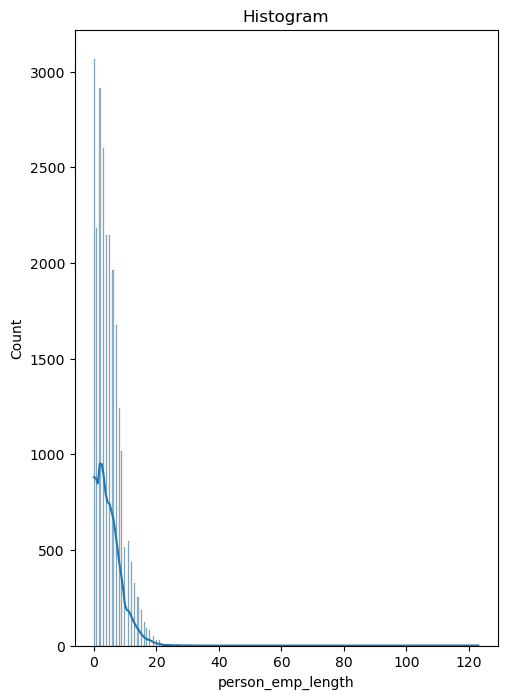

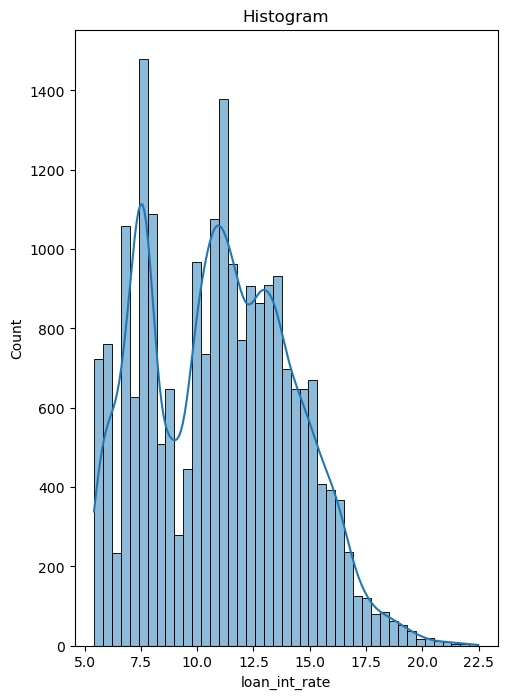

In [822]:
columns = ['person_emp_length', 'loan_int_rate']

for column in columns:
    plt.figure(figsize=(12, 8))
    plt.subplot(1, 2, 1)
    sns.histplot(df[column].dropna(), kde=True)
    plt.title('Histogram')
    plt.show()

Let’s replace the zero values with the median, since the distribution is not normal.

In [824]:
for column in columns:
    df[column] = df[column].fillna(df[column].median())

/var/folders/g_/dlksrxdd3pz88bqsmz91cx540000gn/T/ipykernel_28061/769256592.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = df[column].fillna(df[column].median())


In [825]:
df.isnull().sum()

person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_status                   0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
dtype: int64

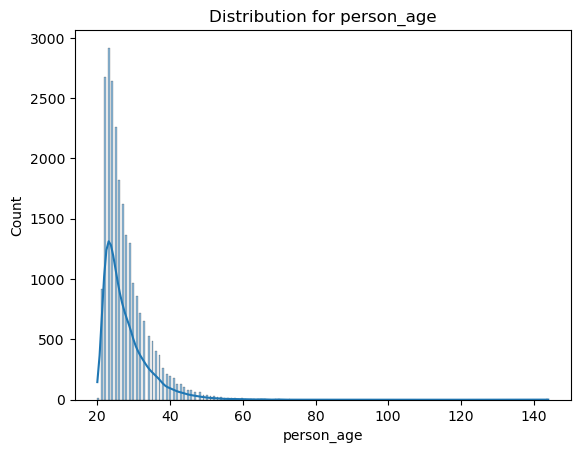

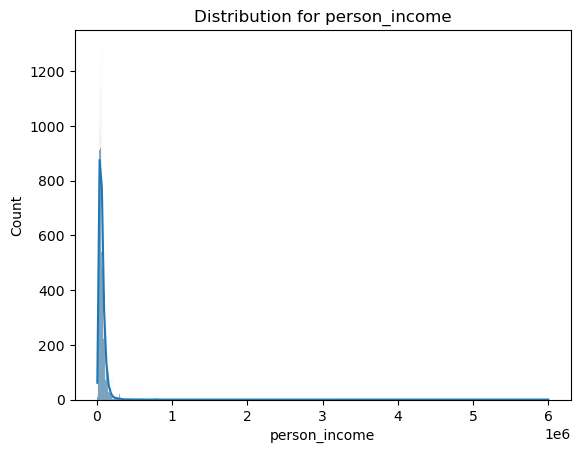

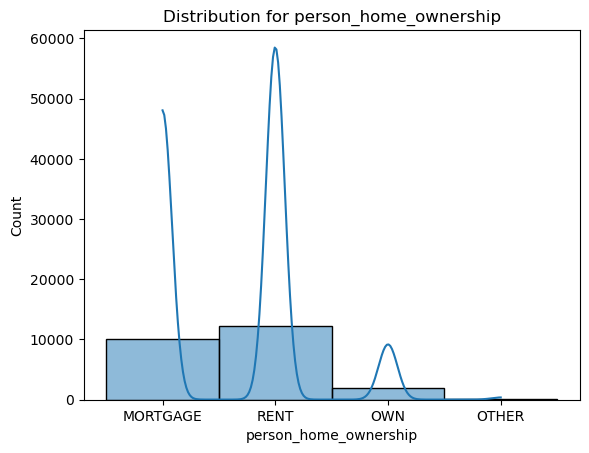

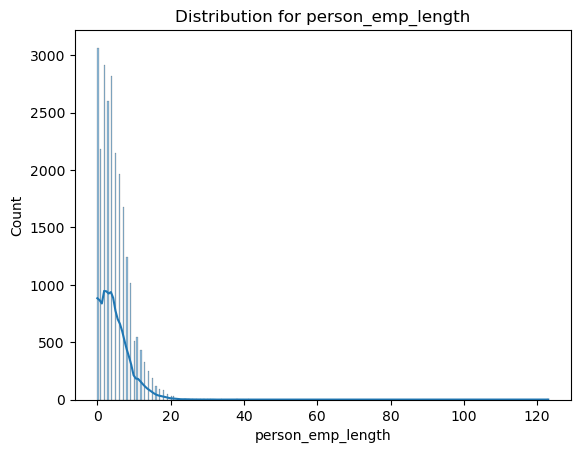

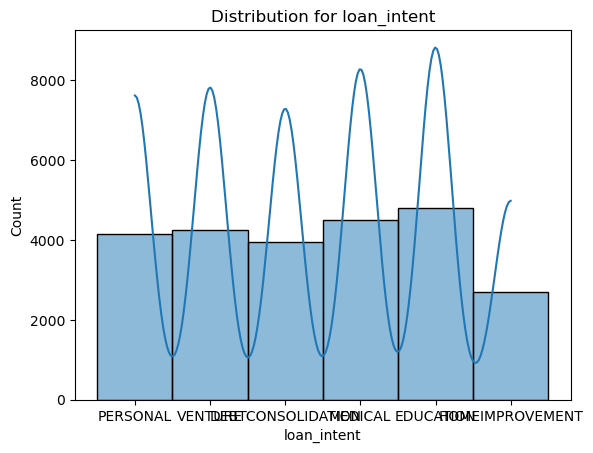

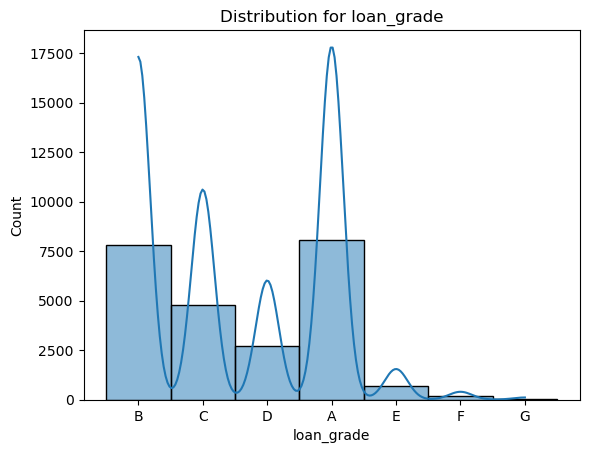

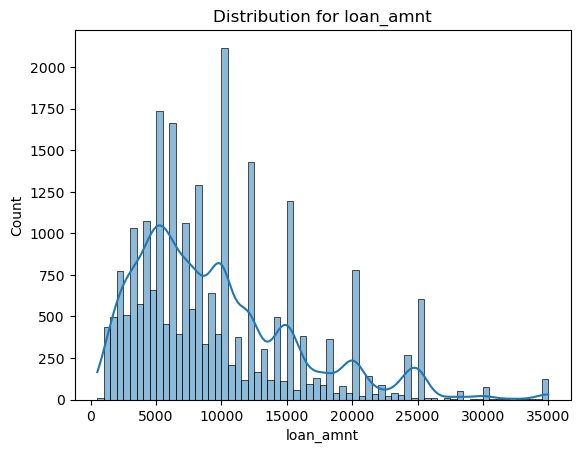

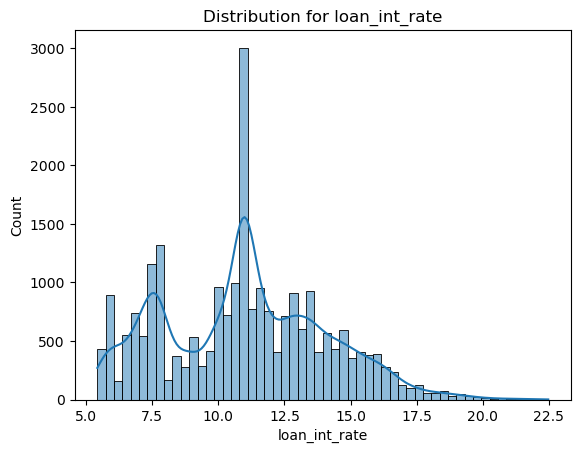

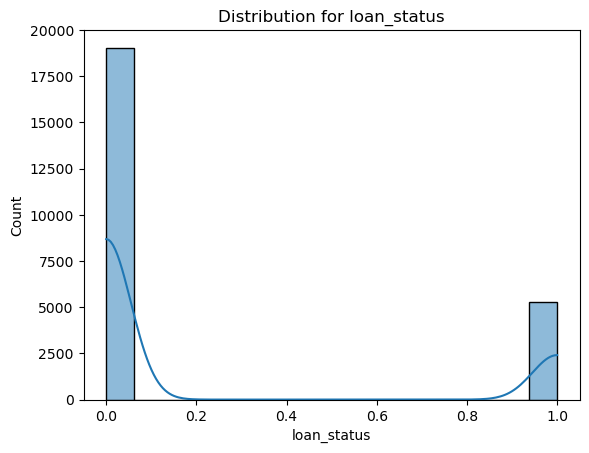

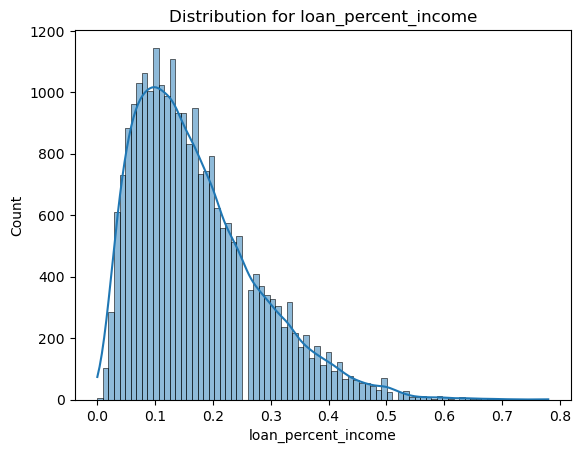

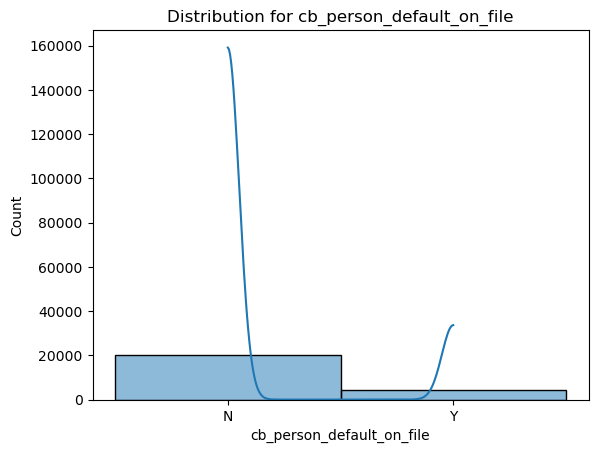

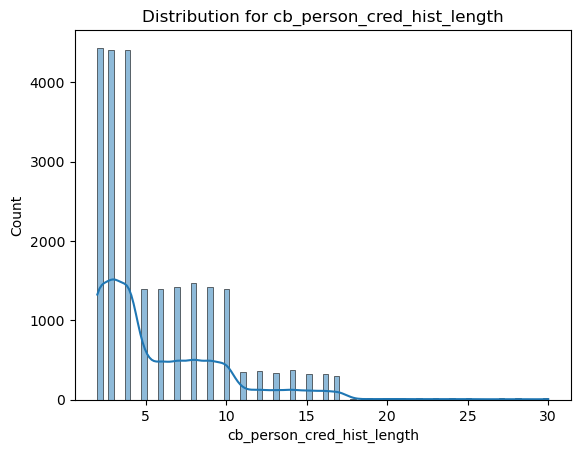

In [829]:
for column in df.columns:
    sns.histplot(df[column].dropna(), kde=True)
    plt.title(f'Distribution for {column}')
    plt.show()

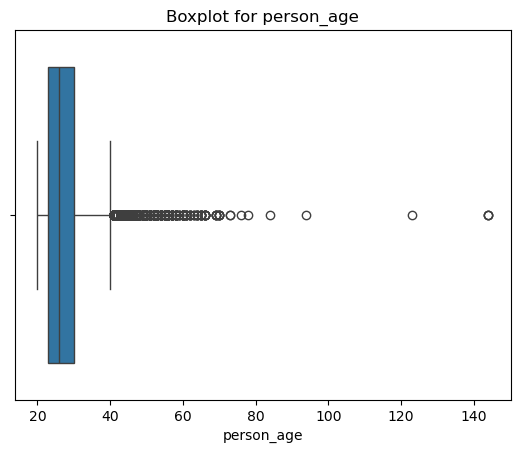

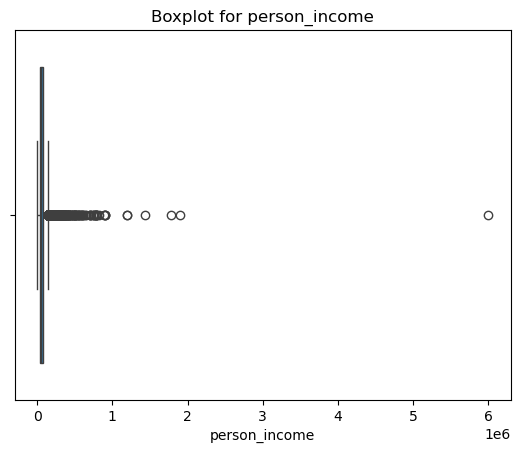

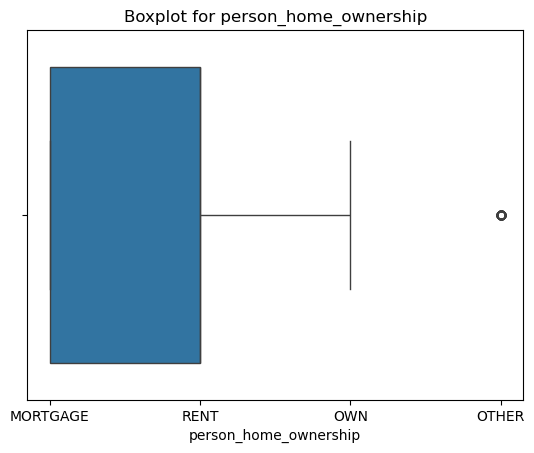

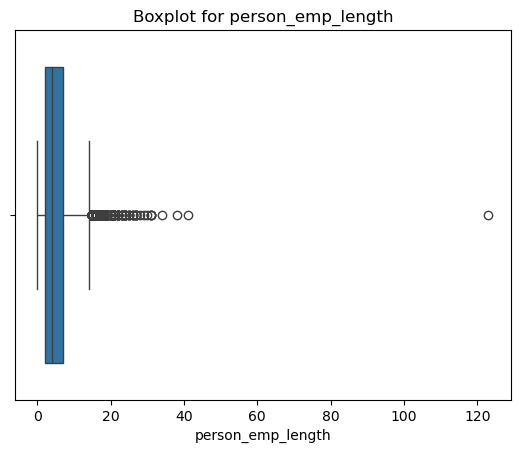

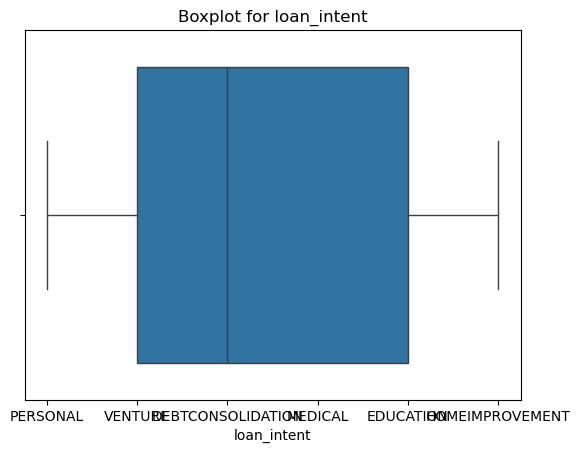

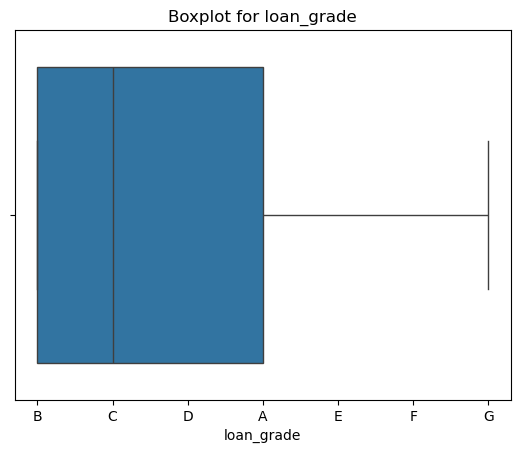

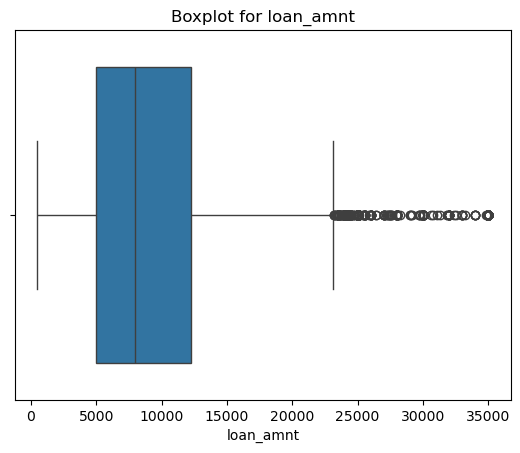

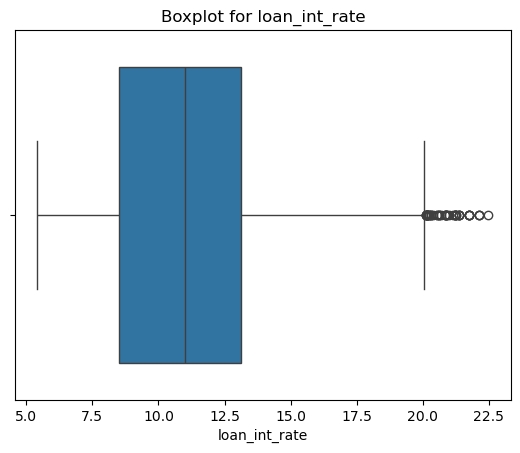

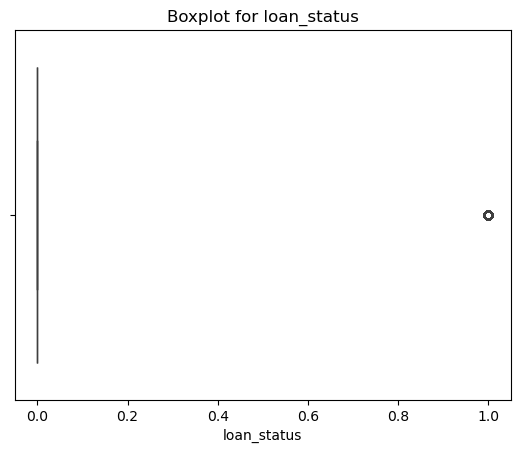

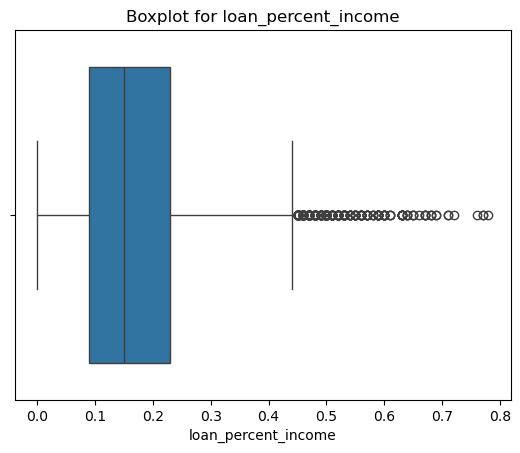

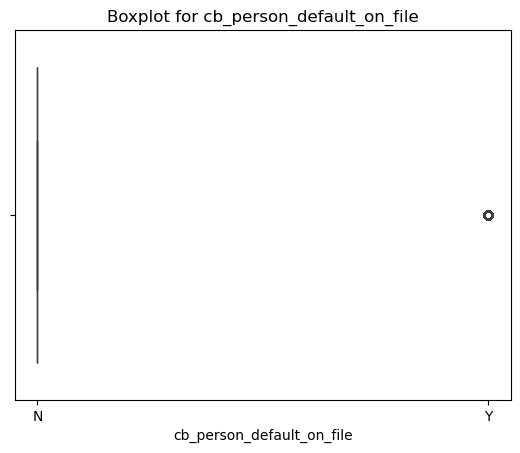

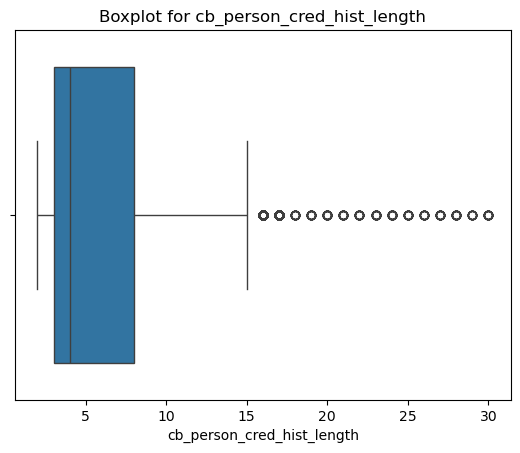

In [830]:
for column in df.columns:
    sns.boxplot(data=df, x=column)
    plt.title(f'Boxplot for {column}')
    plt.show()

<Axes: xlabel='person_age', ylabel='Count'>

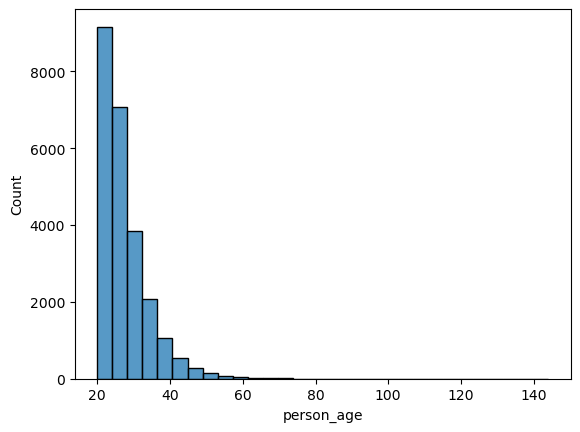

In [831]:
sns.histplot(df['person_age'], bins=30)

We observe that the person_age variable includes clients aged 80+ and even over 100. These entries are clearly incorrect values, and since they are few in number, we have decided to remove them.

In [833]:
df = df[df['person_age'] <= 80]

In [834]:
df['person_income'].describe()

count    2.432600e+04
mean     6.593198e+04
std      5.190047e+04
min      4.000000e+03
25%      3.900000e+04
50%      5.500000e+04
75%      7.943400e+04
max      1.900000e+06
Name: person_income, dtype: float64

In [835]:
df[df['person_income'] > 1_000_000]

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
4533,36,1200000,OWN,16.0,MEDICAL,A,10000,6.54,0,0.01,N,11
11056,44,1440000,MORTGAGE,7.0,DEBTCONSOLIDATION,A,6400,7.40,0,0.00,N,15
19662,60,1900000,MORTGAGE,5.0,PERSONAL,A,1500,10.99,0,0.00,N,21
20730,32,1200000,MORTGAGE,1.0,VENTURE,A,12000,7.51,0,0.01,N,8
21074,63,1782000,RENT,13.0,EDUCATION,C,12025,14.27,0,0.01,N,30


In the person_income column, we observe several clients with significantly higher income than the average. However, after analyzing other variables, we conclude that these values are valid, and we will create a "high income" flag to mark them.

In [837]:
df['is_high_income'] = (df['person_income'] > 1_000_000).astype(int)

In [838]:
df[df['person_emp_length'] > 30]

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,is_high_income
5584,53,106000,MORTGAGE,38.0,PERSONAL,B,20000,9.88,0,0.19,N,23,0
6185,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3,0
8213,78,48000,RENT,41.0,MEDICAL,A,3000,7.51,0,0.06,N,25,0
12158,48,70000,MORTGAGE,31.0,HOMEIMPROVEMENT,D,9000,14.54,0,0.13,N,17,0
13094,47,178000,OWN,31.0,VENTURE,B,9000,10.99,0,0.05,N,17,0
14448,58,49000,MORTGAGE,34.0,MEDICAL,D,7500,13.55,1,0.15,Y,24,0
20466,46,180000,MORTGAGE,31.0,MEDICAL,B,18000,9.91,0,0.10,N,12,0
22865,46,180000,MORTGAGE,31.0,VENTURE,B,18000,9.91,0,0.10,N,11,0


We see that in the person_emp_length column, there is a client aged 22 with 123 years of work experience. This is clearly an anomaly, so we will replace this value with the median employment length for clients aged 22. The other high values appear to be valid and will be retained.

In [840]:
median_emp_length_22 = df.loc[
    (df['person_age'] == 22) & (df['person_emp_length'] <= 100),
    'person_emp_length'
].median()

df.loc[
    (df['person_age'] == 22) & (df['person_emp_length'] > 100),
    'person_emp_length'
] = median_emp_length_22

In [841]:
df.loc[6185]

person_age                          22
person_income                    59000
person_home_ownership             RENT
person_emp_length                  4.0
loan_intent                   PERSONAL
loan_grade                           D
loan_amnt                        35000
loan_int_rate                    16.02
loan_status                          1
loan_percent_income               0.59
cb_person_default_on_file            Y
cb_person_cred_hist_length           3
is_high_income                       0
Name: 6185, dtype: object

In [842]:
df['loan_amnt'].describe()

count    24326.000000
mean      9589.160774
std       6303.199289
min        500.000000
25%       5000.000000
50%       8000.000000
75%      12250.000000
max      35000.000000
Name: loan_amnt, dtype: float64

In [843]:
df['loan_int_rate'].describe()

count    24326.000000
mean        11.000879
std          3.072789
min          5.420000
25%          8.490000
50%         10.990000
75%         13.110000
max         22.480000
Name: loan_int_rate, dtype: float64

In [844]:
df[df['loan_percent_income'] > 0.5]

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,is_high_income
41,22,36000,RENT,6.0,DEBTCONSOLIDATION,B,18200,11.71,1,0.51,N,3,0
231,29,8500,RENT,7.0,VENTURE,A,4500,8.63,1,0.53,N,10,0
305,27,13500,RENT,2.0,MEDICAL,B,8000,12.18,1,0.59,N,5,0
347,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2,0
356,24,43896,RENT,8.0,HOMEIMPROVEMENT,B,23975,10.99,1,0.55,N,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
23228,23,23000,RENT,3.0,EDUCATION,C,12700,14.27,1,0.55,Y,4,0
23261,32,12000,RENT,2.0,EDUCATION,A,6200,6.17,1,0.52,N,9,0
23348,31,39000,MORTGAGE,5.0,EDUCATION,B,22000,11.36,1,0.56,N,5,0
23628,29,40000,MORTGAGE,13.0,HOMEIMPROVEMENT,B,25000,11.86,0,0.63,N,6,0


In [845]:
df[
    (df['cb_person_cred_hist_length'] > 15) &
    (df['person_age'] < 30)
]

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,is_high_income


In [846]:
df.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length,is_high_income
count,24326.000000,2.432600e+04,24326.000000,24326.000000,24326.000000,24326.000000,24326.000000,24326.000000,24326.000000
mean,27.743525,6.593198e+04,4.755036,9589.160774,11.000879,0.217052,0.170180,5.816698,0.000206
std,6.217010,5.190047e+04,3.986881,6303.199289,3.072789,0.412247,0.106772,4.045444,0.014336
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000,0.000000
25%,23.000000,3.900000e+04,2.000000,5000.000000,8.490000,0.000000,0.090000,3.000000,0.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,10.990000,0.000000,0.150000,4.000000,0.000000
75%,30.000000,7.943400e+04,7.000000,12250.000000,13.110000,0.000000,0.230000,8.000000,0.000000
max,78.000000,1.900000e+06,41.000000,35000.000000,22.480000,1.000000,0.780000,30.000000,1.000000


In [847]:
df['cb_person_default_on_file'].describe()

count     24326
unique        2
top           N
freq      20079
Name: cb_person_default_on_file, dtype: object

In [848]:
df

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,is_high_income
0,26,200100,MORTGAGE,10.0,PERSONAL,B,30000,11.71,0,0.15,N,4,0
1,31,64450,RENT,3.0,VENTURE,C,12000,12.73,0,0.19,N,8,0
2,22,22292,RENT,5.0,DEBTCONSOLIDATION,D,3500,16.49,1,0.16,N,3,0
3,33,109000,MORTGAGE,4.0,MEDICAL,B,15000,11.49,0,0.14,N,5,0
4,24,100000,MORTGAGE,8.0,EDUCATION,A,16800,7.88,0,0.17,N,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
24430,39,38500,MORTGAGE,7.0,MEDICAL,C,3500,13.98,0,0.09,Y,17,0
24431,25,69000,RENT,5.0,HOMEIMPROVEMENT,A,8500,6.92,1,0.12,N,4,0
24432,26,148000,RENT,1.0,DEBTCONSOLIDATION,E,20000,17.99,1,0.14,N,3,0
24433,26,175000,MORTGAGE,0.0,PERSONAL,C,15000,10.99,0,0.09,N,3,0


Thus, incorrect outlier values have been handled, while valid outliers have been retained for further analysis. During the modeling stage, we will apply techniques to mitigate their influence.

Duplicates, missing, and incorrect values have been handled — the data is now ready for further processing.

In [852]:
df_cleared = df
df_cleared.to_csv('credit_risk_cleared_data.csv', index=False)

<h3>Researching analysis</h3>

In [854]:
df.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length,is_high_income
count,24326.000000,2.432600e+04,24326.000000,24326.000000,24326.000000,24326.000000,24326.000000,24326.000000,24326.000000
mean,27.743525,6.593198e+04,4.755036,9589.160774,11.000879,0.217052,0.170180,5.816698,0.000206
std,6.217010,5.190047e+04,3.986881,6303.199289,3.072789,0.412247,0.106772,4.045444,0.014336
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000,0.000000
25%,23.000000,3.900000e+04,2.000000,5000.000000,8.490000,0.000000,0.090000,3.000000,0.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,10.990000,0.000000,0.150000,4.000000,0.000000
75%,30.000000,7.943400e+04,7.000000,12250.000000,13.110000,0.000000,0.230000,8.000000,0.000000
max,78.000000,1.900000e+06,41.000000,35000.000000,22.480000,1.000000,0.780000,30.000000,1.000000


<h5>Financial Profile:</h5>
What is the average loan_percent_income across different income levels?<br>

In [860]:
bins = [0, 20000, 50000, 100000, 200000, 500000, 1000000, float('inf')]
labels = ['under 20K', '20–50K', '50–100K', '100–200K', '200–500K', '500K–1M', '1M+']

df['income_group'] = pd.cut(df['person_income'], bins=bins, labels=labels)

grouped = df.groupby('income_group', observed=True)['loan_percent_income'].agg(['mean', 'count']).reset_index()
grouped.rename(columns={'mean': 'avg_loan_percent_income', 'count': 'clients'}, inplace=True)

grouped

,income_group,avg_loan_percent_income,clients
0,under 20K,0.246507,876
1,20–50K,0.204398,9613
2,50–100K,0.152907,10684
3,100–200K,0.107863,2827
4,200–500K,0.068982,285
5,500K–1M,0.019722,36
6,1M+,0.006000,5


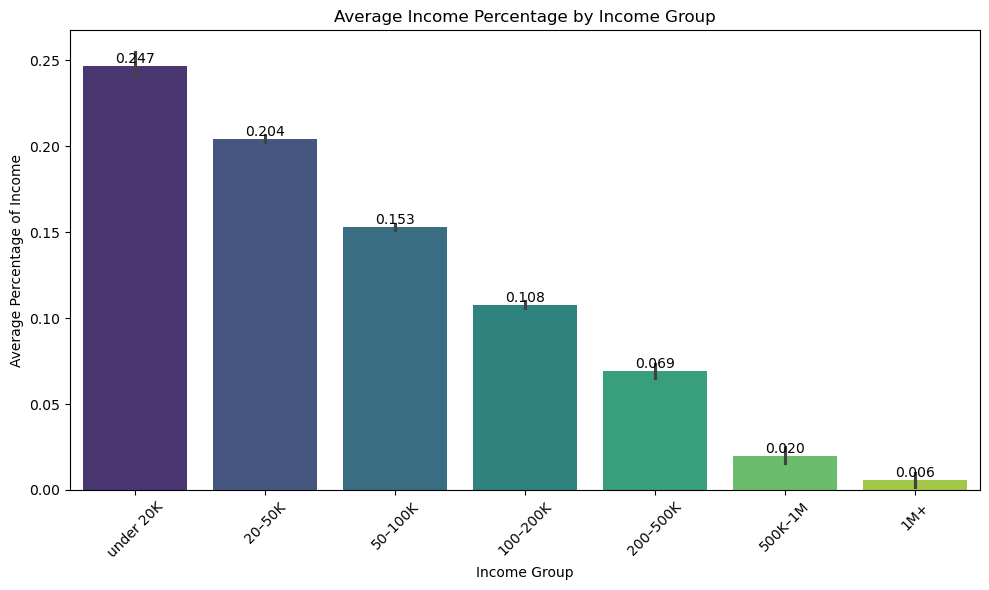

In [862]:
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=df, x='income_group', y='loan_percent_income', hue='income_group', palette='viridis')

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.3f}', 
                (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='bottom', fontsize=10)

plt.title('Average Income Percentage by Income Group')
plt.xlabel('Income Group')
plt.ylabel('Average Percentage of Income')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Who most often takes out large loans — by age, experience, property type?<br>

In [872]:
high_loan_threshold = df['loan_amnt'].quantile(0.75) # large loan
df['is_large_loan'] = (df['loan_amnt'] > high_loan_threshold).astype(int)

df['age_group'] = pd.cut(df['person_age'], bins=[17, 25, 35, 45, 60, 80], 
                         labels=['18–25', '26–35', '36–45', '46–60', '60+'])
age_analysis = df.groupby('age_group', observed=True)['is_large_loan'].mean().reset_index()

df['work_group'] = pd.cut(df['person_emp_length'], bins=[-1, 2, 5, 10, 20, 100],
                          labels=['0–2 года', '3–5 лет', '6–10 лет', '11–20 лет', '20+ лет'])
emp_analysis = df.groupby('work_group', observed=True)['is_large_loan'].mean().reset_index()

ownership_analysis = df.groupby('person_home_ownership')['is_large_loan'].mean().reset_index()

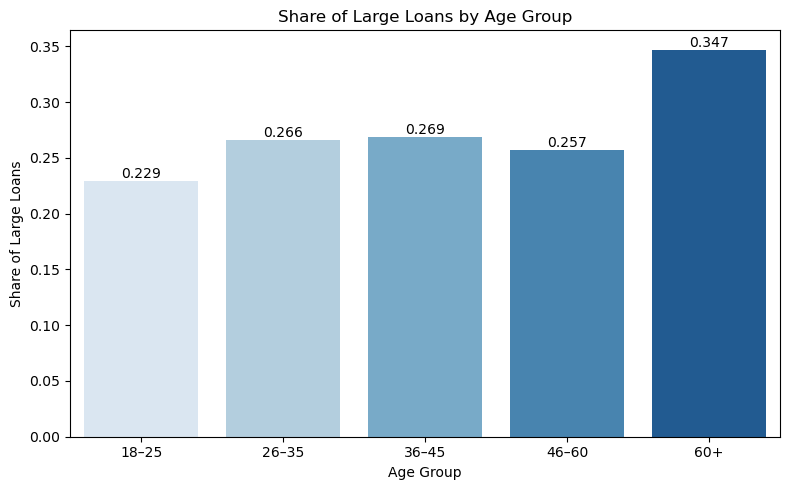

In [877]:
plt.figure(figsize=(8, 5))
ax = sns.barplot(data=age_analysis, x='age_group', y='is_large_loan', hue='age_group', palette='Blues')

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.3f}', 
                (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='bottom', fontsize=10, color='black')

plt.title('Share of Large Loans by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Share of Large Loans')
plt.tight_layout()
plt.show()

How are income and interest rate (loan_int_rate) related?<br>

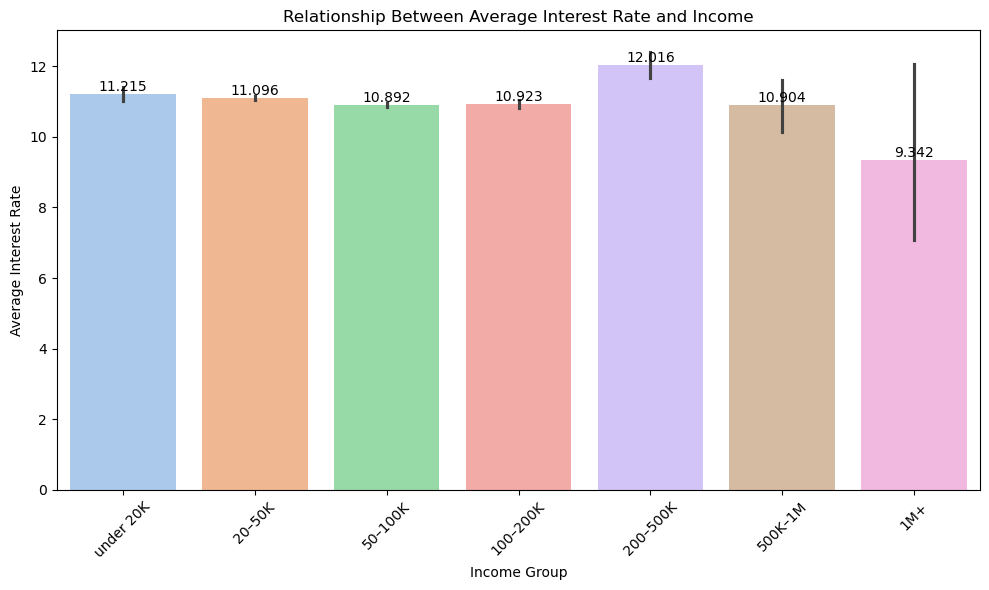

In [884]:
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=df, x='income_group', y='loan_int_rate', hue='income_group', palette='pastel')

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.3f}', 
                (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='bottom', fontsize=10)

plt.title('Relationship Between Average Interest Rate and Income')
plt.xlabel('Income Group')
plt.ylabel('Average Interest Rate')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

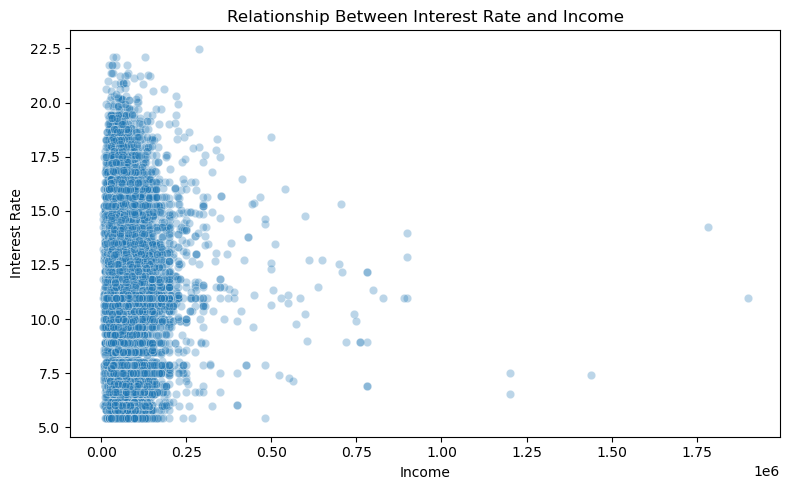

In [885]:
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df, x='person_income', y='loan_int_rate', alpha=0.3)
plt.title('Relationship Between Interest Rate and Income')
plt.xlabel('Income')
plt.ylabel('Interest Rate')
plt.tight_layout()
plt.show()

How does loan_percent_income vary depending on credit grade (loan_grade)?<br>

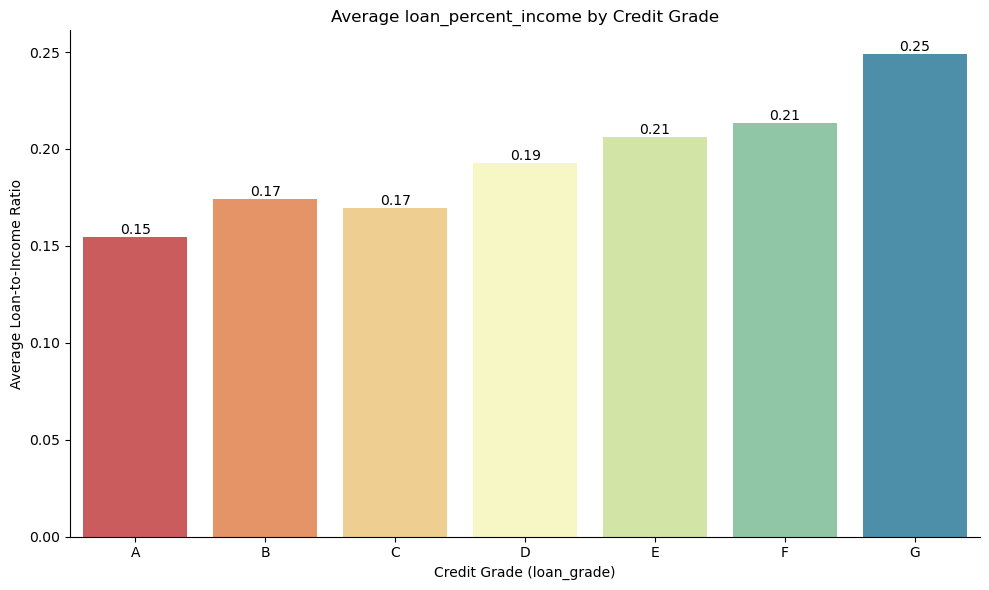

In [889]:
grade_lpi = df.groupby('loan_grade', observed=True)['loan_percent_income'].agg(['mean', 'count']).reset_index()
grade_lpi.rename(columns={'mean': 'avg_loan_percent_income', 'count': 'clients'}, inplace=True)

plt.figure(figsize=(10, 6))
ax = sns.barplot(data=grade_lpi, x='loan_grade', y='avg_loan_percent_income', hue='loan_grade', palette='Spectral')

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.2f}', 
                (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='bottom', fontsize=10)

plt.title('Average loan_percent_income by Credit Grade')
plt.xlabel('Credit Grade (loan_grade)')
plt.ylabel('Average Loan-to-Income Ratio')
sns.despine()
plt.tight_layout()
plt.show()

<h5>Credit History and Risk:</h5>
How does credit history length (cred_hist_length) affect loan amount?<br>

In [892]:
df['cred_hist_group'] = pd.cut(
    df['cb_person_cred_hist_length'],
    bins=[1, 5, 10, 15, 20, 25, 30],
    labels=['2–5 лет', '6–10', '11–15', '16–20', '21–25', '26–30']
)

grouped = df.groupby('cred_hist_group', observed=True)['loan_amnt'].agg(['mean', 'count']).reset_index()
grouped.rename(columns={'mean': 'avg_loan_amnt', 'count': 'clients'}, inplace=True)

grouped

,cred_hist_group,avg_loan_amnt,clients
0,2–5 лет,9370.777558,14642
1,6–10,9887.242958,7100
2,11–15,10016.556955,1747
3,16–20,10019.469027,678
4,21–25,9486.944444,90
5,26–30,10342.391304,69


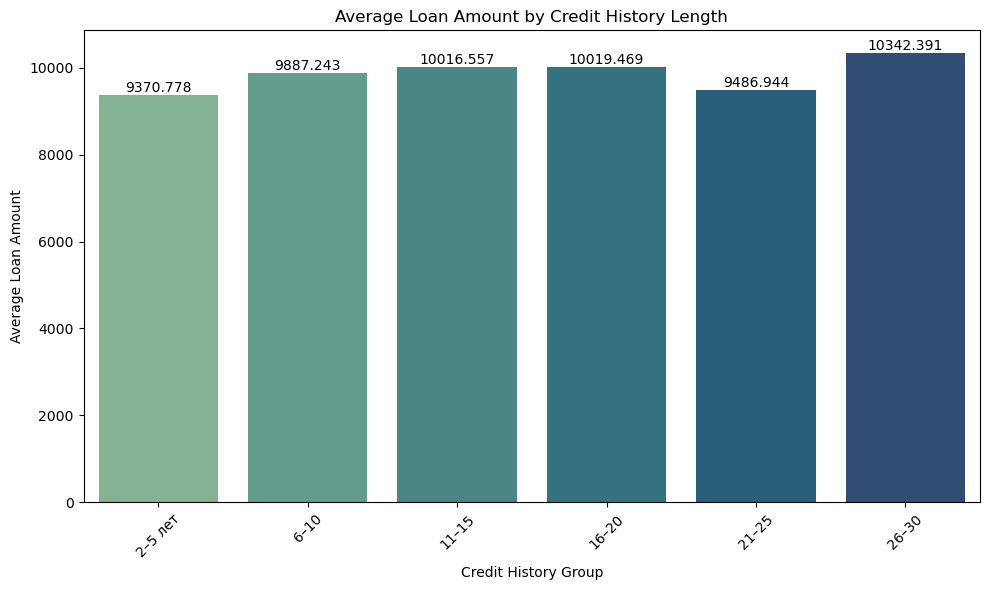

In [893]:
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=grouped, x='cred_hist_group', y='avg_loan_amnt', hue='cred_hist_group', palette='crest')

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.3f}', 
                (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='bottom', fontsize=10)

plt.title('Average Loan Amount by Credit History Length')
plt.xlabel('Credit History Group')
plt.ylabel('Average Loan Amount')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

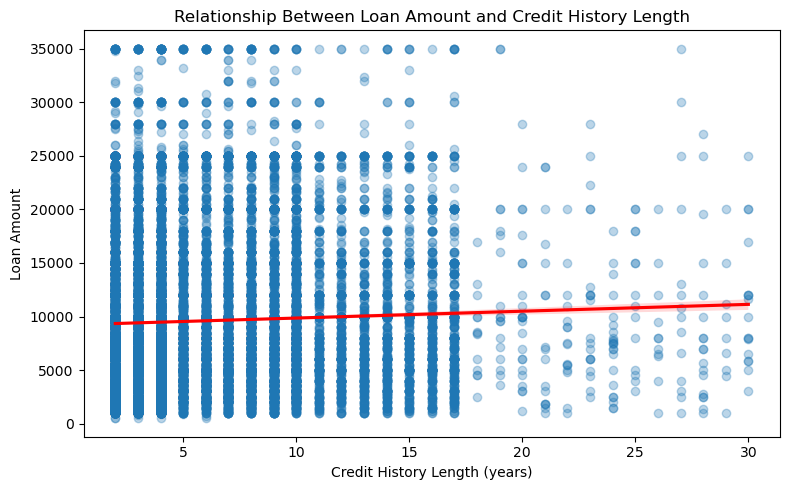

In [896]:
plt.figure(figsize=(8, 5))
sns.regplot(data=df, 
            x='cb_person_cred_hist_length', 
            y='loan_amnt',
            scatter_kws={'alpha': 0.3},
            line_kws={'color': 'red'})
plt.title('Relationship Between Loan Amount and Credit History Length')
plt.xlabel('Credit History Length (years)')
plt.ylabel('Loan Amount')
plt.tight_layout()
plt.show()

What is the average credit history length across age groups?<br>

In [898]:
age_credit_hist_length = df.groupby('age_group', observed=True)['cb_person_cred_hist_length'].mean().reset_index()

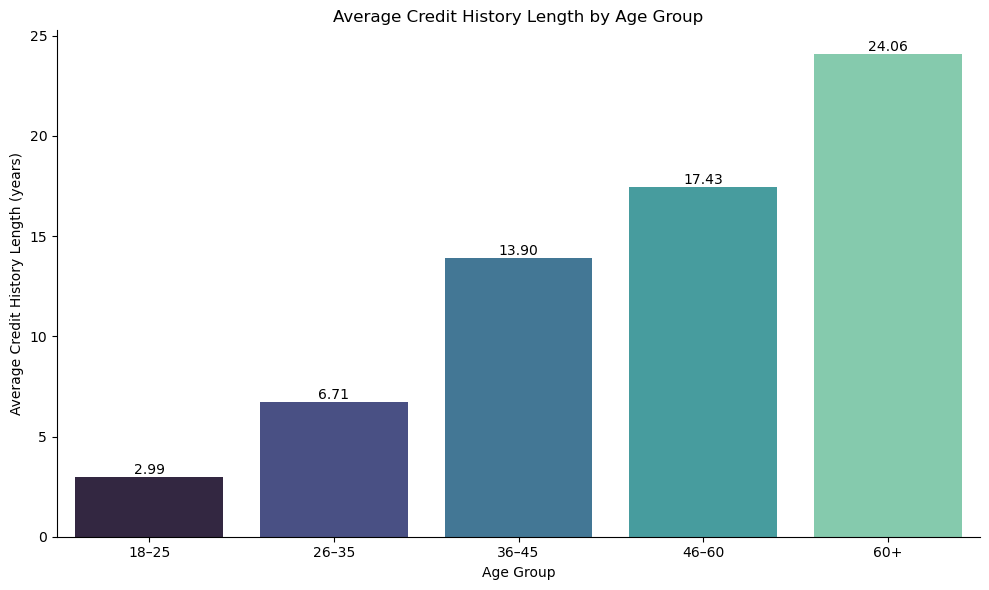

In [899]:
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=age_credit_hist_length, x='age_group', y='cb_person_cred_hist_length', hue='age_group', palette='mako')

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.2f}', 
                (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='bottom', fontsize=10)

plt.title('Average Credit History Length by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Average Credit History Length (years)')
sns.despine()
plt.tight_layout()
plt.show()

How is default history (cb_person_default_on_file) related to interest rate?<br>

In [904]:
df['cb_person_default_on_file'] = df['cb_person_default_on_file'].astype(str)

grouped = df.groupby('cb_person_default_on_file', observed=True)['loan_int_rate'].agg(['mean', 'count']).reset_index()
grouped.rename(columns={'mean': 'avg_int_rate', 'count': 'clients'}, inplace=True)

grouped

,cb_person_default_on_file,avg_int_rate,clients
0,N,10.327742,20079
1,Y,14.183341,4247


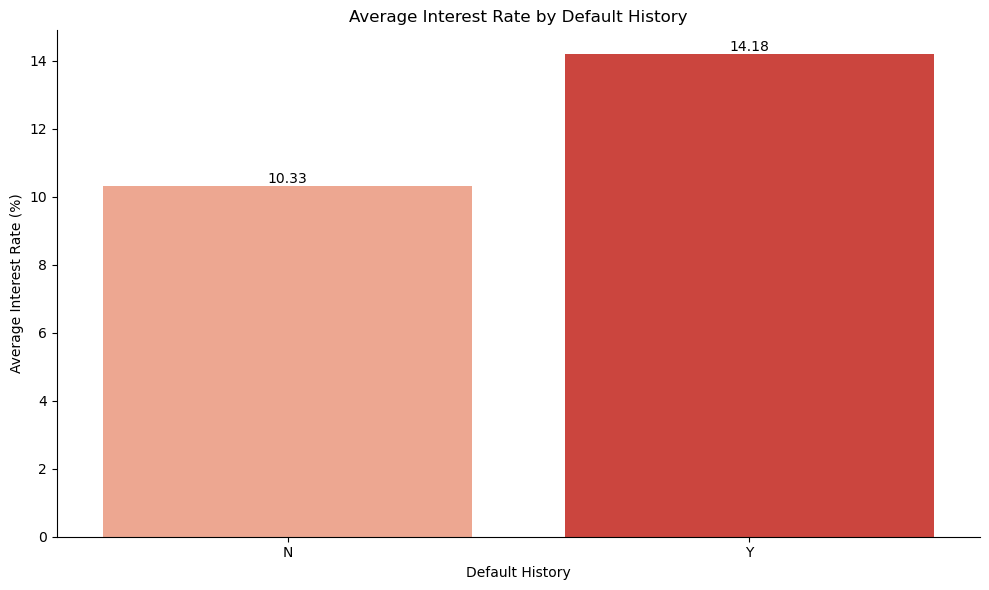

In [905]:
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=grouped, x='cb_person_default_on_file', y='avg_int_rate', hue='cb_person_default_on_file', palette='Reds')

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.2f}', 
                (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='bottom', fontsize=10)

plt.title('Average Interest Rate by Default History')
plt.xlabel('Default History')
plt.ylabel('Average Interest Rate (%)')
sns.despine()
plt.tight_layout()
plt.show()

Who has more defaults — by age, loan purpose, or employment status?<br>

In [909]:
df['age_group'] = pd.cut(df['person_age'], bins=[17, 25, 35, 45, 60, 80],
                         labels=['18–25', '26–35', '36–45', '46–60', '60+'])
age_default = df.groupby('age_group', observed=True)['cb_person_default_on_file'].apply(
    lambda x: (x == 'Y').mean()
).reset_index(name='default_rate')


intent_default = df.groupby('loan_intent', observed=True)['cb_person_default_on_file'].apply(
    lambda x: (x == 'Y').mean()
).reset_index(name='default_rate')


df['emp_group'] = pd.cut(df['person_emp_length'], bins=[-1, 2, 5, 10, 20, 100],
                         labels=['0–2 года', '3–5 лет', '6–10 лет', '11–20 лет', '20+ лет'])
emp_default = df.groupby('emp_group', observed=True)['cb_person_default_on_file'].apply(
    lambda x: (x == 'Y').mean()
).reset_index(name='default_rate')

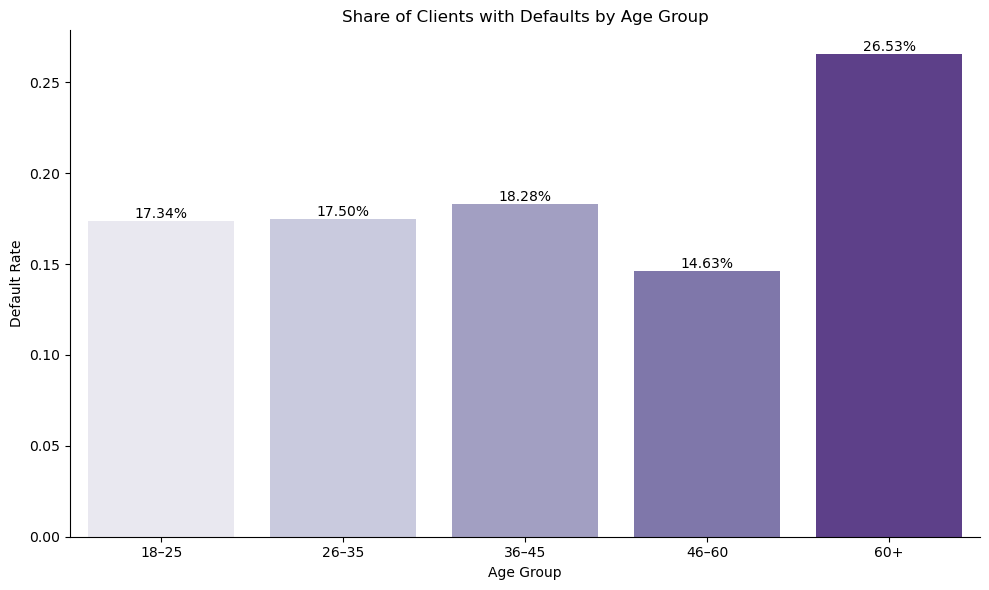

In [911]:
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=age_default, x='age_group', y='default_rate', hue='age_group', palette='Purples')

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.2%}', 
                (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='bottom', fontsize=10)

plt.title('Share of Clients with Defaults by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Default Rate')
sns.despine()
plt.tight_layout()
plt.show()

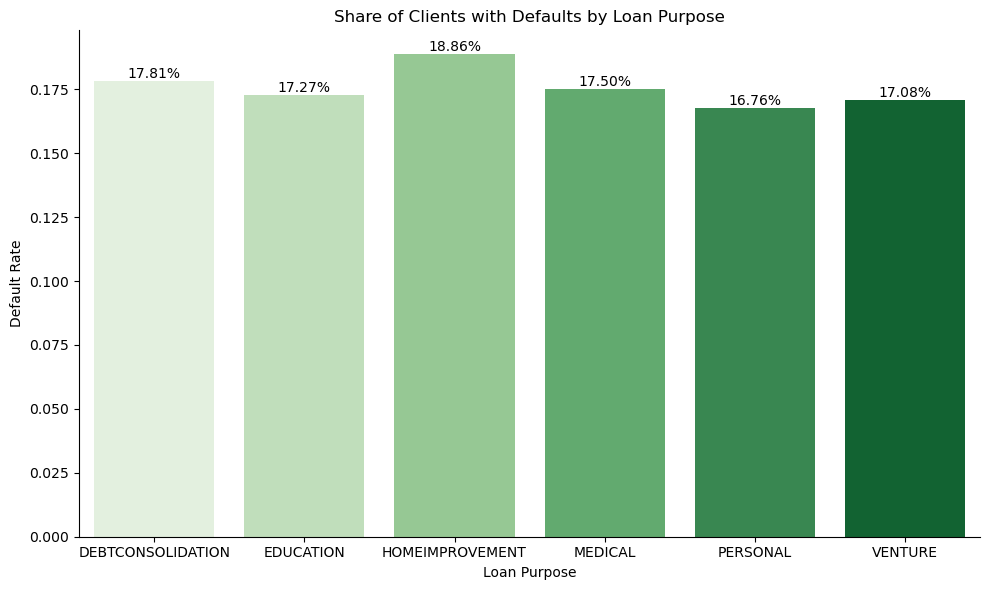

In [913]:
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=intent_default, x='loan_intent', y='default_rate', hue='loan_intent', palette='Greens')

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.2%}', 
                (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='bottom', fontsize=10)

plt.title('Share of Clients with Defaults by Loan Purpose')
plt.xlabel('Loan Purpose')
plt.ylabel('Default Rate')
sns.despine()
plt.tight_layout()
plt.show()


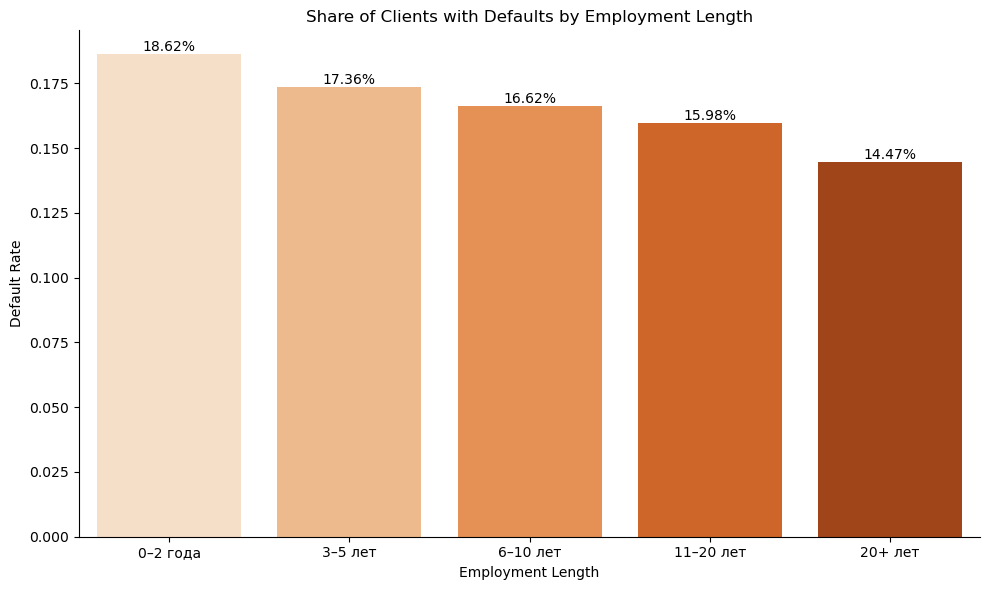

In [915]:
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=emp_default, x='emp_group', y='default_rate', hue='emp_group', palette='Oranges')

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.2%}', 
                (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='bottom', fontsize=10)

plt.title('Share of Clients with Defaults by Employment Length')
plt.xlabel('Employment Length')
plt.ylabel('Default Rate')
sns.despine()
plt.tight_layout()
plt.show()

<h5>Dependence on Loan Purpose:</h5>
        Which loan purposes are more frequently associated with larger loan amounts?<br>

In [918]:
large_loan_by_intent = df.groupby('loan_intent', observed=True)['is_large_loan'].mean().reset_index()
large_loan_by_intent

,loan_intent,is_large_loan
0,DEBTCONSOLIDATION,0.250632
1,EDUCATION,0.239557
2,HOMEIMPROVEMENT,0.295488
3,MEDICAL,0.229982
4,PERSONAL,0.239903
5,VENTURE,0.256302


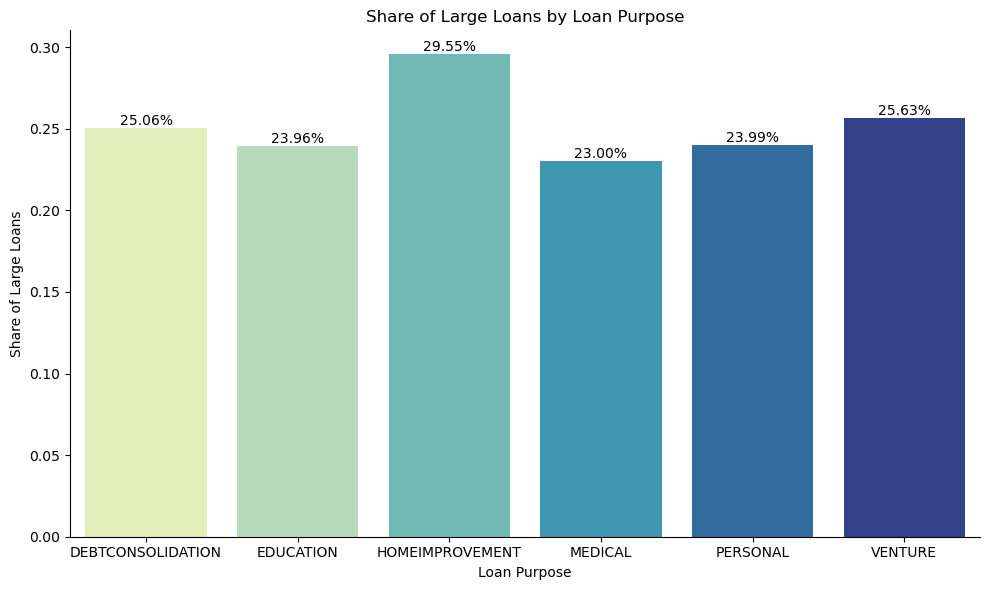

In [920]:
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=large_loan_by_intent, x='loan_intent', y='is_large_loan', hue='loan_intent', palette='YlGnBu')

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.2%}', 
                (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='bottom', fontsize=10)

plt.title('Share of Large Loans by Loan Purpose')
plt.xlabel('Loan Purpose')
plt.ylabel('Share of Large Loans')
sns.despine()
plt.tight_layout()
plt.show()

Which loan intents have a higher share of borrowers with default history?<br>

In [923]:
default_by_intent = df.groupby('loan_intent', observed=True)['cb_person_default_on_file'].apply(
    lambda x: (x == 'Y').mean()
).reset_index(name='default_rate')

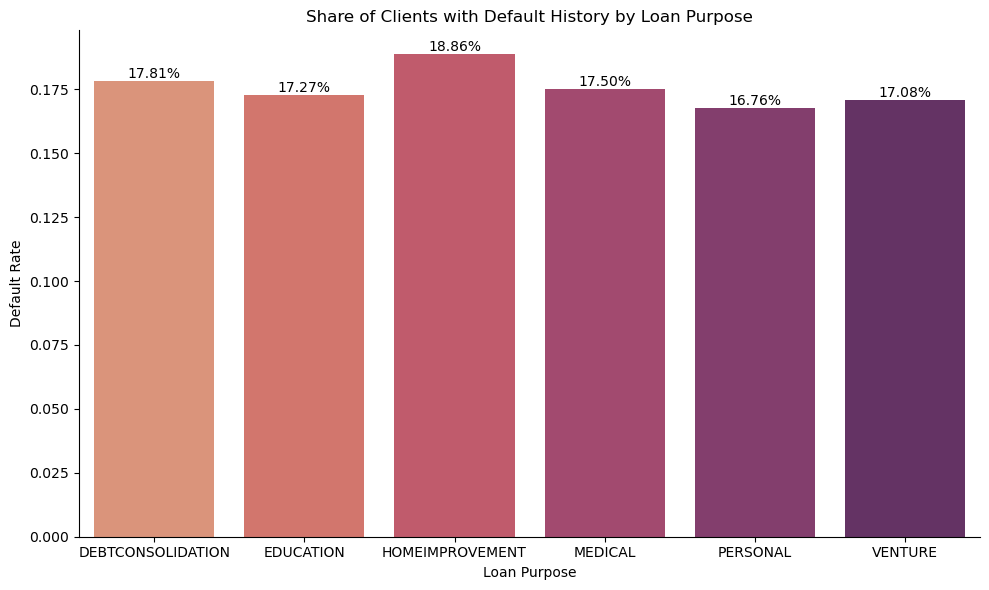

In [925]:
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=default_by_intent, x='loan_intent', y='default_rate', hue='loan_intent', palette='flare')

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.2%}', 
                (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='bottom', fontsize=10)

plt.title('Share of Clients with Default History by Loan Purpose')
plt.xlabel('Loan Purpose')
plt.ylabel('Default Rate')
sns.despine()
plt.tight_layout()
plt.show()

<h5>For the Classification Model:</h5>

How does loan_grade affect default probability?<br>

In [929]:
default_by_grade = df.groupby('loan_grade', observed=True)['loan_status'].mean().reset_index()

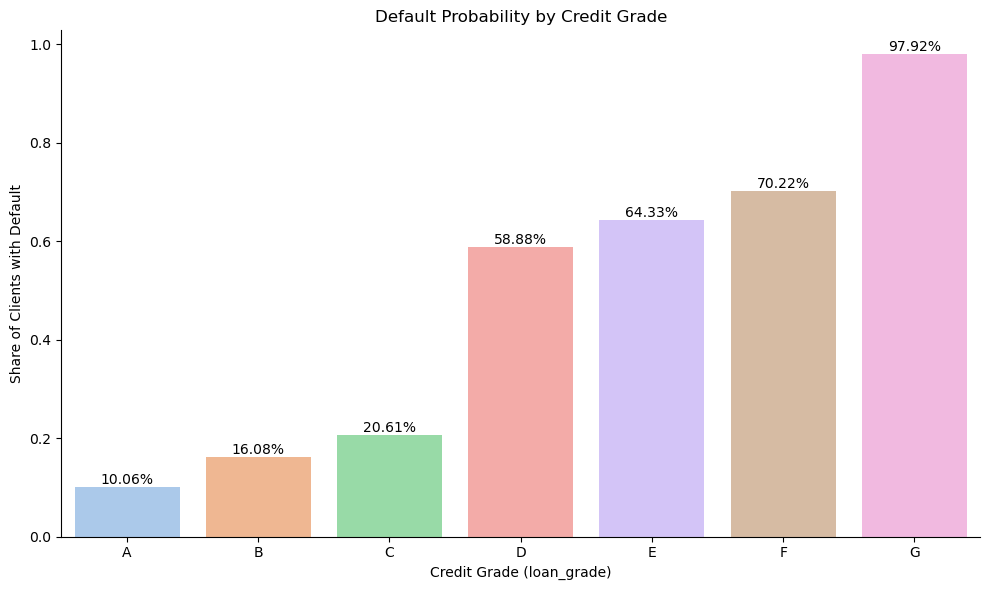

In [931]:
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=default_by_grade, x='loan_grade', y='loan_status', hue='loan_grade', palette='pastel')

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.2%}', 
                (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='bottom', fontsize=10)

plt.title('Default Probability by Credit Grade')
plt.xlabel('Credit Grade (loan_grade)')
plt.ylabel('Share of Clients with Default')
sns.despine()
plt.tight_layout()
plt.show()


Which features are correlated?<br>

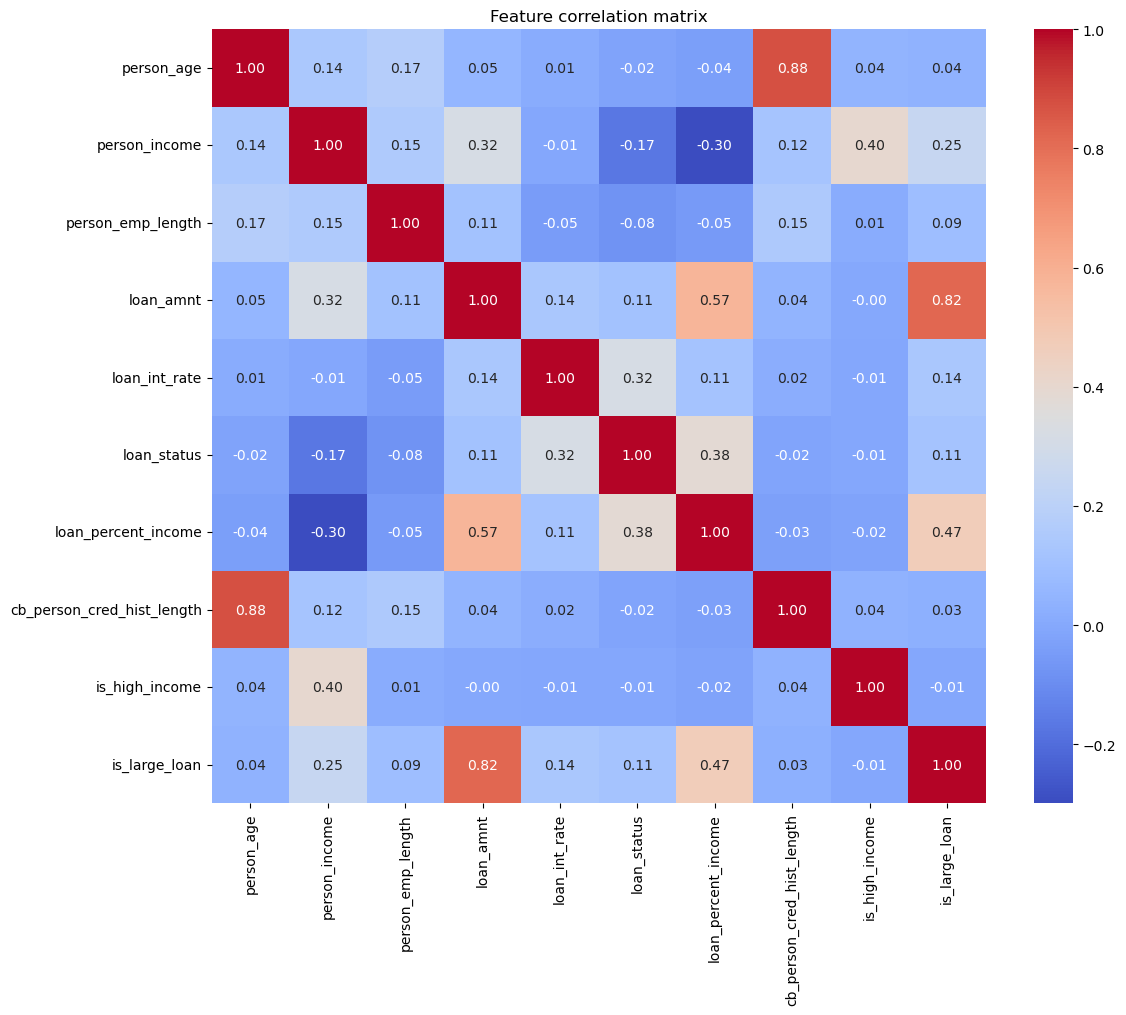

In [934]:
numeric_df = df.select_dtypes(include=['int64', 'float64'])

corr_matrix = numeric_df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Feature correlation matrix')
plt.tight_layout()
plt.show()

Encoding categorical variables and scaling all features<br>

We encode categorical variables using the One-Hot Encoding method since these variables do not have a natural order.

In [938]:
df = pd.get_dummies(df, columns=['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file'])
bool_columns = df.select_dtypes(include=['bool']).columns
df[bool_columns] = df[bool_columns].astype(int)

We normalize numerical variables to ensure consistency in scale. For variables with a small range, we use Min-Max Scaler. For other data, since they do not follow a normal distribution and contain outliers, we first apply Robust Scaler and then Min-Max Scaler to bring them to a common scale.

In [941]:
df.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length,is_high_income,is_large_loan,...,loan_intent_VENTURE,loan_grade_A,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,cb_person_default_on_file_N,cb_person_default_on_file_Y
count,24326.000000,2.432600e+04,24326.000000,24326.000000,24326.000000,24326.000000,24326.000000,24326.000000,24326.000000,24326.000000,...,24326.000000,24326.000000,24326.000000,24326.000000,24326.000000,24326.000000,24326.000000,24326.000000,24326.000000,24326.000000
mean,27.743525,6.593198e+04,4.755036,9589.160774,11.000879,0.217052,0.170180,5.816698,0.000206,0.248787,...,0.174505,0.331538,0.321549,0.197073,0.111856,0.028694,0.007317,0.001973,0.825413,0.174587
std,6.217010,5.190047e+04,3.986881,6303.199289,3.072789,0.412247,0.106772,4.045444,0.014336,0.432319,...,0.379551,0.470776,0.467081,0.397796,0.315195,0.166947,0.085229,0.044378,0.379621,0.379621
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,23.000000,3.900000e+04,2.000000,5000.000000,8.490000,0.000000,0.090000,3.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,10.990000,0.000000,0.150000,4.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,30.000000,7.943400e+04,7.000000,12250.000000,13.110000,0.000000,0.230000,8.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,78.000000,1.900000e+06,41.000000,35000.000000,22.480000,1.000000,0.780000,30.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [943]:
scaler = RobustScaler()
df['person_age'] = scaler.fit_transform(df[['person_age']])
df['person_income'] = scaler.fit_transform(df[['person_income']])
df['loan_amnt'] = scaler.fit_transform(df[['loan_amnt']])
df['person_emp_length'] = scaler.fit_transform(df[['person_emp_length']])
df['loan_int_rate'] = scaler.fit_transform(df[['loan_int_rate']])
df['cb_person_cred_hist_length'] = scaler.fit_transform(df[['cb_person_cred_hist_length']])

scaler = MinMaxScaler()
df['person_age'] = scaler.fit_transform(df[['person_age']])
df['person_income'] = scaler.fit_transform(df[['person_income']])
df['loan_amnt'] = scaler.fit_transform(df[['loan_amnt']])
df['person_emp_length'] = scaler.fit_transform(df[['person_emp_length']])
df['loan_int_rate'] = scaler.fit_transform(df[['loan_int_rate']])
df['cb_person_cred_hist_length'] = scaler.fit_transform(df[['cb_person_cred_hist_length']])

In [945]:
df.columns

Index(['person_age', 'person_income', 'person_emp_length', 'loan_amnt',
       'loan_int_rate', 'loan_status', 'loan_percent_income',
       'cb_person_cred_hist_length', 'is_high_income', 'income_group',
       'is_large_loan', 'age_group', 'work_group', 'cred_hist_group',
       'emp_group', 'person_home_ownership_MORTGAGE',
       'person_home_ownership_OTHER', 'person_home_ownership_OWN',
       'person_home_ownership_RENT', 'loan_intent_DEBTCONSOLIDATION',
       'loan_intent_EDUCATION', 'loan_intent_HOMEIMPROVEMENT',
       'loan_intent_MEDICAL', 'loan_intent_PERSONAL', 'loan_intent_VENTURE',
       'loan_grade_A', 'loan_grade_B', 'loan_grade_C', 'loan_grade_D',
       'loan_grade_E', 'loan_grade_F', 'loan_grade_G',
       'cb_person_default_on_file_N', 'cb_person_default_on_file_Y'],
      dtype='object')

In [947]:
df = df.drop(columns=['age_group', 'work_group', 'cred_hist_group', 'emp_group', 'income_group'])
df

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length,is_high_income,is_large_loan,...,loan_intent_VENTURE,loan_grade_A,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,cb_person_default_on_file_N,cb_person_default_on_file_Y
0,0.103448,0.103428,0.243902,0.855072,0.368699,0,0.15,0.071429,0,1,...,0,0,1,0,0,0,0,0,1,0
1,0.189655,0.031883,0.073171,0.333333,0.428488,0,0.19,0.214286,0,0,...,1,0,0,1,0,0,0,0,1,0
2,0.034483,0.009648,0.121951,0.086957,0.648886,1,0.16,0.035714,0,0,...,0,0,0,0,1,0,0,0,1,0
3,0.224138,0.055380,0.097561,0.420290,0.355803,0,0.14,0.107143,0,1,...,0,0,1,0,0,0,0,0,1,0
4,0.068966,0.050633,0.195122,0.472464,0.144197,0,0.17,0.071429,0,1,...,0,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24430,0.327586,0.018196,0.170732,0.086957,0.501758,0,0.09,0.535714,0,0,...,0,0,0,1,0,0,0,0,0,1
24431,0.086207,0.034283,0.121951,0.231884,0.087925,1,0.12,0.071429,0,0,...,0,1,0,0,0,0,0,0,1,0
24432,0.103448,0.075949,0.024390,0.565217,0.736811,1,0.14,0.035714,0,1,...,0,0,0,0,0,1,0,0,1,0
24433,0.103448,0.090190,0.000000,0.420290,0.326495,0,0.09,0.035714,0,1,...,0,0,0,1,0,0,0,0,1,0


In [949]:
df.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length,is_high_income,is_large_loan,...,loan_intent_VENTURE,loan_grade_A,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,cb_person_default_on_file_N,cb_person_default_on_file_Y
count,24326.000000,24326.000000,24326.000000,24326.000000,24326.000000,24326.000000,24326.000000,24326.000000,24326.000000,24326.000000,...,24326.000000,24326.000000,24326.000000,24326.000000,24326.000000,24326.000000,24326.000000,24326.000000,24326.000000,24326.000000
mean,0.133509,0.032665,0.115976,0.263454,0.327132,0.217052,0.170180,0.136311,0.000206,0.248787,...,0.174505,0.331538,0.321549,0.197073,0.111856,0.028694,0.007317,0.001973,0.825413,0.174587
std,0.107190,0.027374,0.097241,0.182701,0.180117,0.412247,0.106772,0.144480,0.014336,0.432319,...,0.379551,0.470776,0.467081,0.397796,0.315195,0.166947,0.085229,0.044378,0.379621,0.379621
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.051724,0.018460,0.048780,0.130435,0.179953,0.000000,0.090000,0.035714,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,0.103448,0.026899,0.097561,0.217391,0.326495,0.000000,0.150000,0.071429,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,0.172414,0.039786,0.170732,0.340580,0.450762,0.000000,0.230000,0.214286,0.000000,0.000000,...,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.780000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


 <h3>Model building</h3>

Which features are most informative for predicting default?<br>

In [953]:
X = df.drop(columns=['loan_status'])
y = df['loan_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred_proba = model.predict_proba(X_test)[:, 1]

print(f"AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")
print(classification_report(y_test, model.predict(X_test)))

AUC: 0.9269
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      3810
           1       0.96      0.72      0.82      1056

    accuracy                           0.93      4866
   macro avg       0.94      0.86      0.89      4866
weighted avg       0.93      0.93      0.93      4866



In [954]:
rf = RandomForestClassifier(random_state=42)

param_dist = {
    'n_estimators': randint(100, 300),
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=30,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=2,
    random_state=42
)
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'max_depth': [10, 20, None],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x30101ede0>},
                   random_state=42, scoring='roc_auc', verbose=2)

Optimal threshold: 0.49


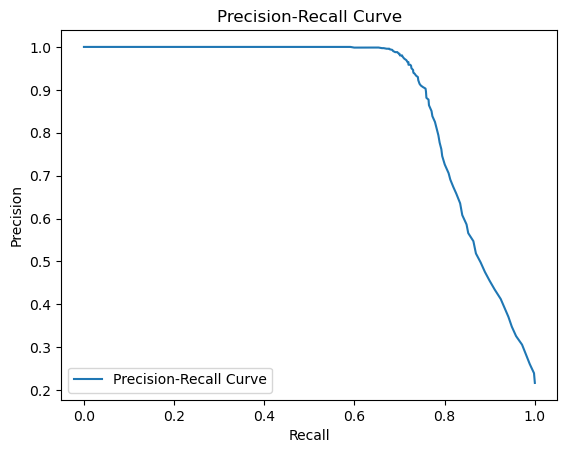

In [955]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

f1_scores = 2 * (precision * recall) / (precision + recall)
optimal_threshold = thresholds[f1_scores.argmax()]

print("Optimal threshold:", optimal_threshold)

plt.plot(recall, precision, label="Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

In [956]:
X = df.drop(columns=['loan_status'])
y = df['loan_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

model = RandomForestClassifier(max_depth=20, min_samples_leaf=2, min_samples_split=5,
                       n_estimators=233, random_state=42)
model.fit(X_train, y_train)

y_pred_proba = model.predict_proba(X_test)[:, 1]
y_pred = (y_pred_proba >= optimal_threshold).astype(int)

print(f"AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")
print(classification_report(y_test, y_pred))

AUC: 0.9262
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      3810
           1       0.97      0.72      0.82      1056

    accuracy                           0.93      4866
   macro avg       0.95      0.86      0.89      4866
weighted avg       0.94      0.93      0.93      4866



ROC-AUC Score: 0.926211176727909


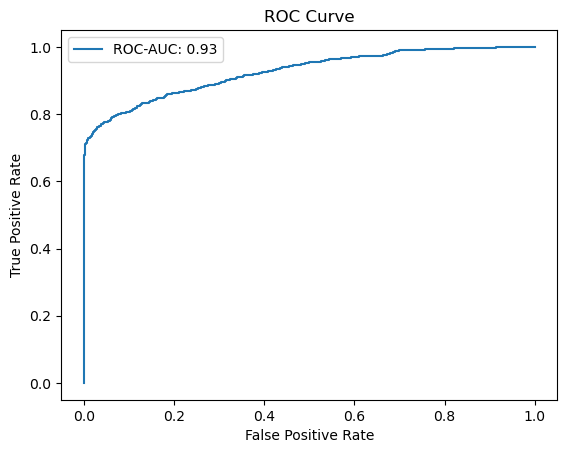

In [957]:
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC-AUC Score: {roc_auc}")

fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f"ROC-AUC: {roc_auc:.2f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

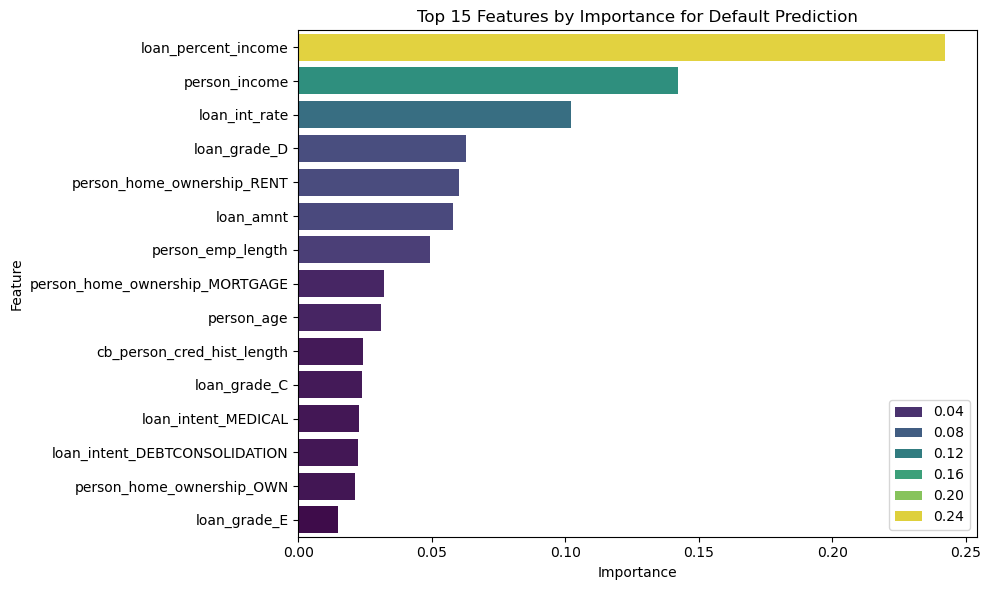

In [959]:
importances = pd.Series(model.feature_importances_, index=X.columns)
top_features = importances.sort_values(ascending=False).head(15)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_features.values, y=top_features.index, hue=top_features.values, palette='viridis')
plt.title('Top 15 Features by Importance for Default Prediction')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


In [960]:
cv_auc = cross_val_score(model, X, y, cv=5, scoring='roc_auc')
print(f"Average CV AUC: {cv_auc.mean():.4f} ± {cv_auc.std():.4f}")

Average CV AUC: 0.9278 ± 0.0083


In [961]:
new_data = pd.read_csv('credit_risk_new_data.csv')

In [962]:
new_data = new_data.drop(columns=['loan_status'])

In [963]:
new_data

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,24,28000,OWN,6.0,HOMEIMPROVEMENT,B,10000,10.37,0.36,N,2
1,27,64000,RENT,0.0,PERSONAL,C,10000,15.27,0.16,Y,10
2,26,72000,MORTGAGE,10.0,EDUCATION,D,16000,NaN,0.22,N,3
3,23,27996,RENT,7.0,DEBTCONSOLIDATION,A,10000,NaN,0.36,N,2
4,30,44500,RENT,2.0,MEDICAL,E,13000,16.32,0.29,N,6
...,...,...,...,...,...,...,...,...,...,...,...
8141,38,66000,RENT,1.0,PERSONAL,D,10000,15.99,0.15,Y,12
8142,27,39000,RENT,3.0,PERSONAL,B,11000,NaN,0.28,N,7
8143,26,70000,RENT,5.0,PERSONAL,C,4000,13.85,0.06,N,4
8144,24,10980,OWN,0.0,PERSONAL,A,1500,7.29,0.14,N,3


Lets prepare new data

In [965]:
new_data.duplicated().sum()

9

In [966]:
new_data = new_data.drop_duplicates()
new_data.duplicated().sum()

0

In [967]:
new_data.isnull().sum()

person_age                      0
person_income                   0
person_home_ownership           0
person_emp_length             217
loan_intent                     0
loan_grade                      0
loan_amnt                       0
loan_int_rate                 807
loan_percent_income             0
cb_person_default_on_file       0
cb_person_cred_hist_length      0
dtype: int64

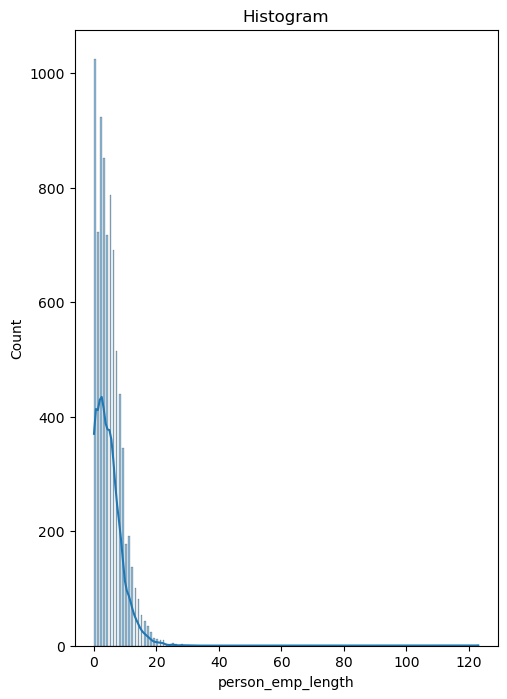

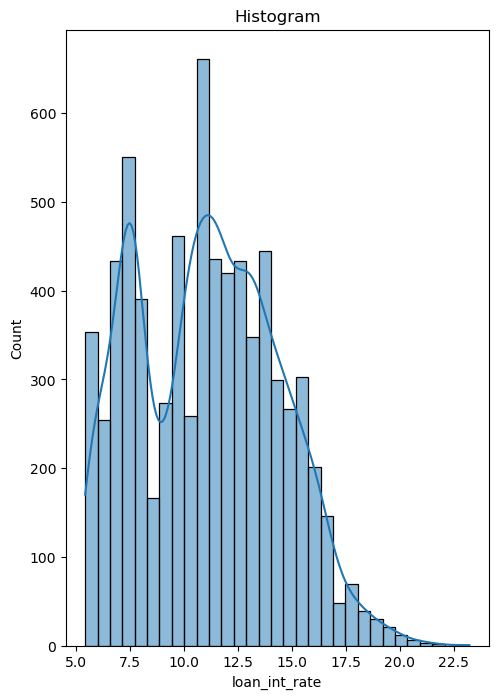

In [968]:
columns = ['person_emp_length', 'loan_int_rate']

for column in columns:
    plt.figure(figsize=(12, 8))
    plt.subplot(1, 2, 1)
    sns.histplot(new_data[column].dropna(), kde=True)
    plt.title('Histogram')
    plt.show()

In [969]:
for column in columns:
    new_data[column] = new_data[column].fillna(new_data[column].median())

/var/folders/g_/dlksrxdd3pz88bqsmz91cx540000gn/T/ipykernel_28061/2743691635.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data[column] = new_data[column].fillna(new_data[column].median())


In [970]:
new_data.isnull().sum()

person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
dtype: int64

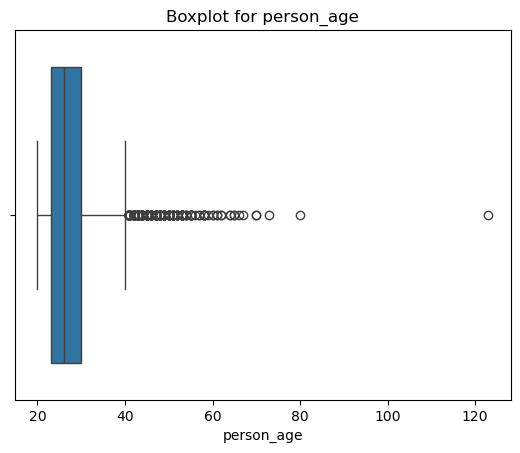

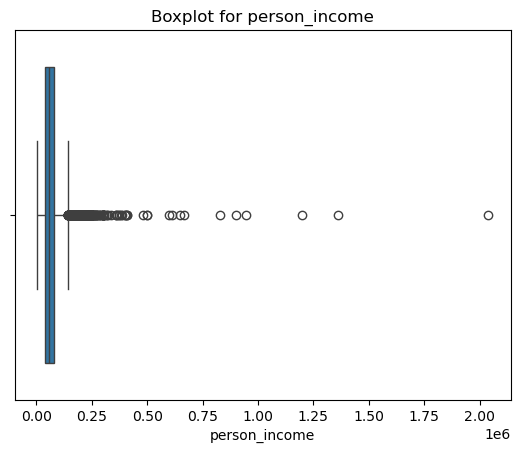

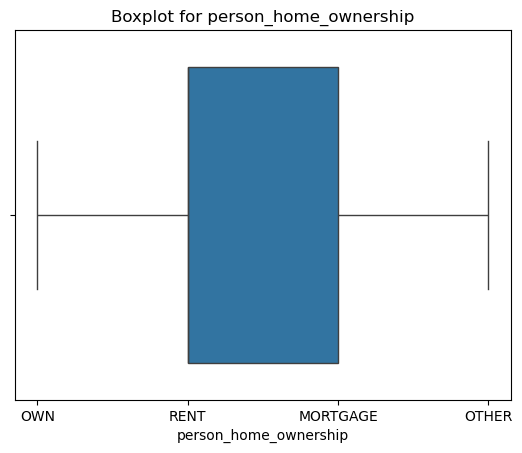

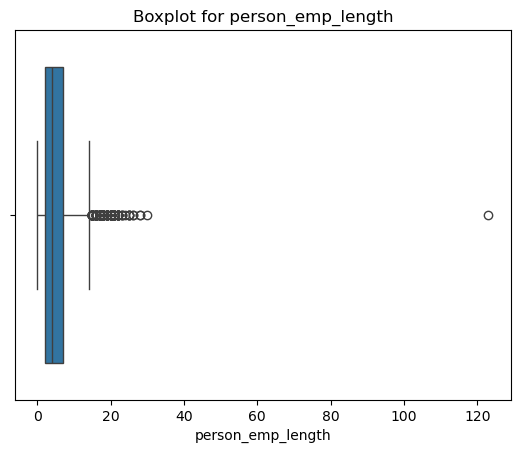

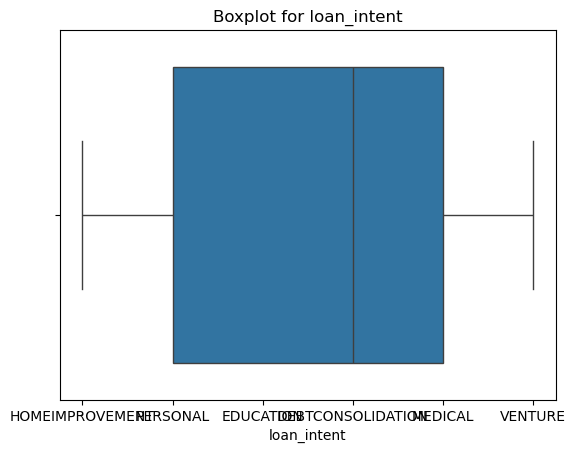

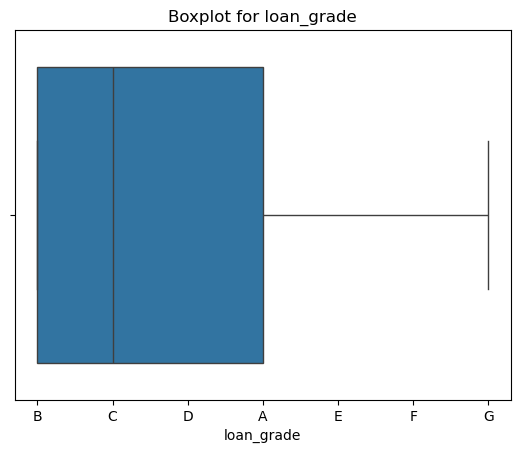

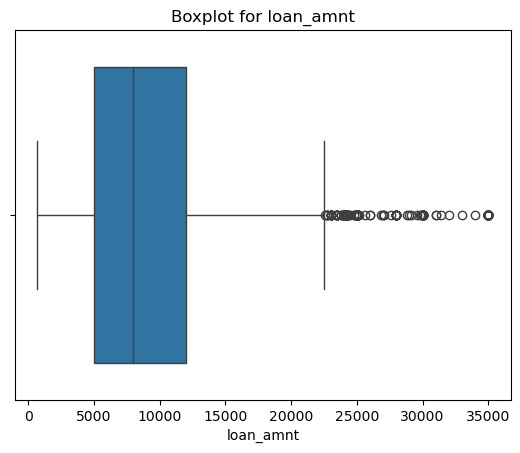

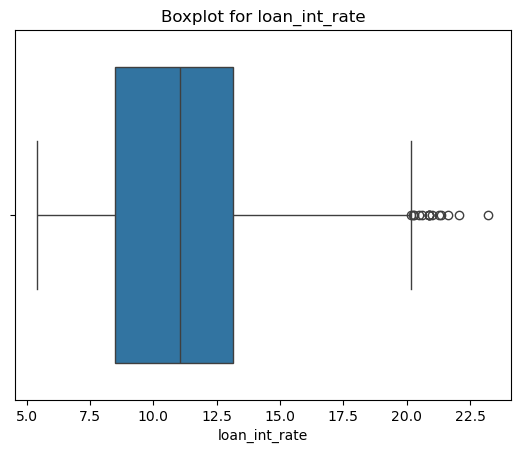

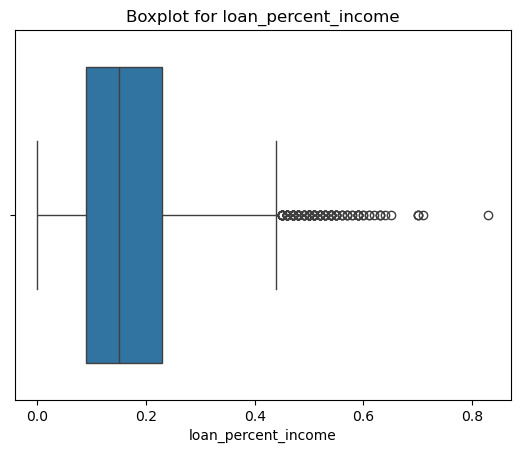

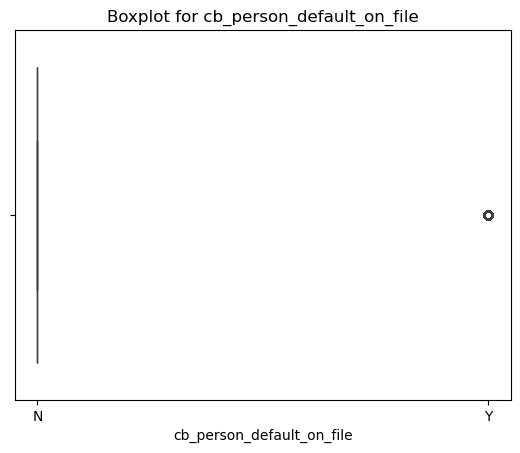

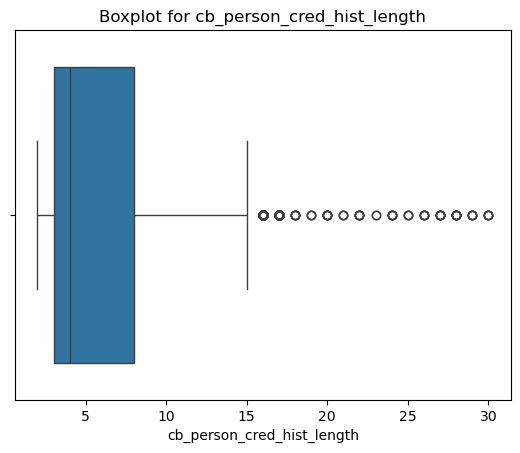

In [971]:
for column in new_data.columns:
    sns.boxplot(data=new_data, x=column)
    plt.title(f'Boxplot for {column}')
    plt.show()

In [972]:
new_data

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,24,28000,OWN,6.0,HOMEIMPROVEMENT,B,10000,10.37,0.36,N,2
1,27,64000,RENT,0.0,PERSONAL,C,10000,15.27,0.16,Y,10
2,26,72000,MORTGAGE,10.0,EDUCATION,D,16000,11.03,0.22,N,3
3,23,27996,RENT,7.0,DEBTCONSOLIDATION,A,10000,11.03,0.36,N,2
4,30,44500,RENT,2.0,MEDICAL,E,13000,16.32,0.29,N,6
...,...,...,...,...,...,...,...,...,...,...,...
8141,38,66000,RENT,1.0,PERSONAL,D,10000,15.99,0.15,Y,12
8142,27,39000,RENT,3.0,PERSONAL,B,11000,11.03,0.28,N,7
8143,26,70000,RENT,5.0,PERSONAL,C,4000,13.85,0.06,N,4
8144,24,10980,OWN,0.0,PERSONAL,A,1500,7.29,0.14,N,3


In [973]:
new_data = new_data[new_data['person_age'] <= 80]

In [974]:
new_data[new_data['person_income'] > 1_000_000]

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
1783,40,1200000,MORTGAGE,1.0,MEDICAL,A,10000,11.03,0.01,N,16
5863,42,2039784,RENT,0.0,VENTURE,C,8450,12.29,0.00,Y,15
6107,47,1362000,MORTGAGE,9.0,VENTURE,A,6600,7.74,0.00,N,17


In [975]:
new_data['is_high_income'] = (new_data['person_income'] > 1_000_000).astype(int)

/var/folders/g_/dlksrxdd3pz88bqsmz91cx540000gn/T/ipykernel_28061/1733025878.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data['is_high_income'] = (new_data['person_income'] > 1_000_000).astype(int)


In [976]:
new_data[new_data['person_emp_length'] > 30]

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,is_high_income
990,21,192000,MORTGAGE,123.0,VENTURE,A,20000,6.54,0.1,N,4,0


In [977]:
median_emp_length_21 = new_data.loc[
    (new_data['person_age'] == 21) & (new_data['person_emp_length'] <= 100),
    'person_emp_length'
].median()

new_data.loc[
    (new_data['person_age'] == 21) & (new_data['person_emp_length'] > 100),
    'person_emp_length'
] = median_emp_length_21

In [978]:
new_data.loc[990]

person_age                          21
person_income                   192000
person_home_ownership         MORTGAGE
person_emp_length                  4.0
loan_intent                    VENTURE
loan_grade                           A
loan_amnt                        20000
loan_int_rate                     6.54
loan_percent_income                0.1
cb_person_default_on_file            N
cb_person_cred_hist_length           4
is_high_income                       0
Name: 990, dtype: object

In [979]:
new_data[
    (new_data['cb_person_cred_hist_length'] > 15) &
    (new_data['person_age'] < 30)
]

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,is_high_income


In [980]:
new_data['loan_amnt'].describe()

count     8136.000000
mean      9593.390487
std       6377.942289
min        700.000000
25%       5000.000000
50%       8000.000000
75%      12000.000000
max      35000.000000
Name: loan_amnt, dtype: float64

In [981]:
new_data['loan_int_rate'].describe()

count    8136.000000
mean       11.051893
std         3.112534
min         5.420000
25%         8.490000
50%        11.030000
75%        13.160000
max        23.220000
Name: loan_int_rate, dtype: float64

In [982]:
new_data[new_data['loan_percent_income'] > 0.5] 

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,is_high_income
59,28,28800,RENT,1.0,EDUCATION,C,15000,14.65,0.52,Y,8,0
284,54,53700,RENT,1.0,HOMEIMPROVEMENT,D,29850,11.03,0.56,Y,28,0
621,25,24000,RENT,3.0,VENTURE,B,13250,10.37,0.55,N,2,0
665,27,30000,RENT,12.0,DEBTCONSOLIDATION,B,16000,10.99,0.53,N,6,0
732,24,43300,MORTGAGE,2.0,DEBTCONSOLIDATION,B,24000,10.62,0.55,N,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...
8000,27,47000,MORTGAGE,2.0,DEBTCONSOLIDATION,D,25000,14.96,0.53,Y,9,0
8038,24,18000,MORTGAGE,0.0,DEBTCONSOLIDATION,B,10000,12.18,0.56,N,2,0
8047,23,47148,MORTGAGE,3.0,MEDICAL,A,25000,7.49,0.53,N,3,0
8054,26,30000,RENT,5.0,DEBTCONSOLIDATION,A,19075,7.49,0.64,N,3,0


In [983]:
high_loan_threshold = new_data['loan_amnt'].quantile(0.75) # large loan
new_data['is_large_loan'] = (new_data['loan_amnt'] > high_loan_threshold).astype(int)

/var/folders/g_/dlksrxdd3pz88bqsmz91cx540000gn/T/ipykernel_28061/2384363406.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data['is_large_loan'] = (new_data['loan_amnt'] > high_loan_threshold).astype(int)


In [984]:
new_data_orig = new_data

Incorrect values have been handled, duplicates and missing entries have been removed — next, we proceed to encode and scale the variables.

In [986]:
new_data = pd.get_dummies(new_data, columns=['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file'])
bool_columns = new_data.select_dtypes(include=['bool']).columns
new_data[bool_columns] = new_data[bool_columns].astype(int)

In [987]:
scaler = RobustScaler()
new_data['person_age'] = scaler.fit_transform(new_data[['person_age']])
new_data['person_income'] = scaler.fit_transform(new_data[['person_income']])
new_data['loan_amnt'] = scaler.fit_transform(new_data[['loan_amnt']])
new_data['person_emp_length'] = scaler.fit_transform(new_data[['person_emp_length']])
new_data['loan_int_rate'] = scaler.fit_transform(new_data[['loan_int_rate']])
new_data['cb_person_cred_hist_length'] = scaler.fit_transform(new_data[['cb_person_cred_hist_length']])

scaler = MinMaxScaler()
new_data['person_age'] = scaler.fit_transform(new_data[['person_age']])
new_data['person_income'] = scaler.fit_transform(new_data[['person_income']])
new_data['loan_amnt'] = scaler.fit_transform(new_data[['loan_amnt']])
new_data['person_emp_length'] = scaler.fit_transform(new_data[['person_emp_length']])
new_data['loan_int_rate'] = scaler.fit_transform(new_data[['loan_int_rate']])
new_data['cb_person_cred_hist_length'] = scaler.fit_transform(new_data[['cb_person_cred_hist_length']])

In [988]:
new_data

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,is_high_income,is_large_loan,person_home_ownership_MORTGAGE,...,loan_intent_VENTURE,loan_grade_A,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,cb_person_default_on_file_N,cb_person_default_on_file_Y
0,0.066667,0.011692,0.200000,0.271137,0.278090,0.36,0.000000,0,0,0,...,0,0,1,0,0,0,0,0,1,0
1,0.116667,0.029377,0.000000,0.271137,0.553371,0.16,0.285714,0,0,0,...,0,0,0,1,0,0,0,0,0,1
2,0.100000,0.033307,0.333333,0.446064,0.315169,0.22,0.035714,0,1,1,...,0,0,0,0,1,0,0,0,1,0
3,0.050000,0.011690,0.233333,0.271137,0.315169,0.36,0.000000,0,0,0,...,0,1,0,0,0,0,0,0,1,0
4,0.166667,0.019798,0.066667,0.358601,0.612360,0.29,0.142857,0,1,0,...,0,0,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8141,0.300000,0.030360,0.033333,0.271137,0.593820,0.15,0.357143,0,0,0,...,0,0,0,0,1,0,0,0,0,1
8142,0.116667,0.017096,0.100000,0.300292,0.315169,0.28,0.178571,0,0,0,...,0,0,1,0,0,0,0,0,1,0
8143,0.100000,0.032325,0.166667,0.096210,0.473596,0.06,0.071429,0,0,0,...,0,0,0,1,0,0,0,0,1,0
8144,0.066667,0.003331,0.000000,0.023324,0.105056,0.14,0.035714,0,0,0,...,0,1,0,0,0,0,0,0,1,0


In [989]:
new_pred_proba = model.predict_proba(new_data)[:, 1]
new_pred_class = (new_pred_proba >= optimal_threshold).astype(int)

In [990]:
new_data_orig['default_probability'] = new_pred_proba
new_data_orig['loan_status'] = new_pred_class

/var/folders/g_/dlksrxdd3pz88bqsmz91cx540000gn/T/ipykernel_28061/2525261645.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data_orig['default_probability'] = new_pred_proba
/var/folders/g_/dlksrxdd3pz88bqsmz91cx540000gn/T/ipykernel_28061/2525261645.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data_orig['loan_status'] = new_pred_class


In [991]:
new_data_orig

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,is_high_income,is_large_loan,default_probability,loan_status
0,24,28000,OWN,6.0,HOMEIMPROVEMENT,B,10000,10.37,0.36,N,2,0,0,0.068756,0
1,27,64000,RENT,0.0,PERSONAL,C,10000,15.27,0.16,Y,10,0,0,0.121867,0
2,26,72000,MORTGAGE,10.0,EDUCATION,D,16000,11.03,0.22,N,3,0,1,0.173404,0
3,23,27996,RENT,7.0,DEBTCONSOLIDATION,A,10000,11.03,0.36,N,2,0,0,0.965158,1
4,30,44500,RENT,2.0,MEDICAL,E,13000,16.32,0.29,N,6,0,1,0.727183,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8141,38,66000,RENT,1.0,PERSONAL,D,10000,15.99,0.15,Y,12,0,0,0.936748,1
8142,27,39000,RENT,3.0,PERSONAL,B,11000,11.03,0.28,N,7,0,0,0.063403,0
8143,26,70000,RENT,5.0,PERSONAL,C,4000,13.85,0.06,N,4,0,0,0.059898,0
8144,24,10980,OWN,0.0,PERSONAL,A,1500,7.29,0.14,N,3,0,0,0.281420,0


In [992]:
new_data_orig.to_csv('new_data_clients_predicted.csv', index=False)